In [1]:
#test!!!
# Basic packages
from IPython.display import display, HTML, clear_output
import warnings
warnings.filterwarnings("ignore")
import os
import argparse
import random 
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

# Torch packages
import torch
from torch    import nn
from torch.nn import functional as F

from torch_geometric.nn import GCNConv, GATv2Conv,GATConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.utils import negative_sampling 
from torch_geometric.data   import Data
from torch_geometric.loader import DataLoader

from torch.nn import Linear
import torch.nn.init as init
# Display options
display(HTML("<style>.container { width:95% !important; }</style>"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #torch.device("cpu")#
pd.set_option('display.width', 2000)
pd.options.display.max_rows = 50
pd.options.display.max_columns = 20
np.random.seed(0)
torch.manual_seed(999)
# Work directory
os.chdir('../data')

## Data loading

In [2]:
data = pd.read_csv('noon_perfumes_dataset.csv')

In [3]:
data.head()

Unnamed: 0            brand               name  old_price  new_price   ml concentration department   scents                                    base_note                                       middle_note  item_rating seller  seller_rating num_seller_ratings
0           0     PACO RABANNE    1 Million Lucky      395.0     244.55  100           EDT        Men    Woody               Oakmoss, Patchouli and Vetiver  Hazelnut, Jasmine, Cashmir Wood, Cedar and Honey          5.0   noon            4.2              98.1K
1           1  Roberto Cavalli  Paradiso Assoluto      415.0     107.95   50           EDP      Women   Floral            Vanilla, Sandalwood And Patchouli                         Wild Jasmine and Red Lily          4.8   noon            4.2              98.1K
2           2       S.T.Dupont        Royal Amber      265.0     186.90  100           EDP     Unisex  Arabian                    Lemon, Mint and Wood Moss                              Sandalwood and Cedar          5.0   noon            4.2              98.1K
3           3            GUESS     Seductive Blue      290.0     103.20  100           EDT        Men    Spicy  Cashmere Wood, Moss And Rippled Sand Accord          Blue Coral Aquaspace Accord And Geranium          3.0   noon            4.2              98.1K
4           4  Roberto Cavalli               Uomo      260.0      94.95   50           EDP      Women  Arabian                 Vanille, Benzoin, Tonka Bean                             African Orange Flower          4.8   noon            4.2              98.1K

In [4]:
data.shape

(1003, 15)

## Data cleaning/ Preprocessing

- Handling missing values

In [5]:
print(data.isnull().sum())
# we have no missing values

Unnamed: 0            0
brand                 0
name                  0
old_price             0
new_price             0
ml                    0
concentration         0
department            0
scents                0
base_note             0
middle_note           0
item_rating           0
seller                0
seller_rating         0
num_seller_ratings    0
dtype: int64


- Concentration

In [6]:
data.concentration.value_counts()

concentration
EDT    503
EDP    494
PDT      3
Oil      2
EDC      1
Name: count, dtype: int64

In [7]:
# We consider 2 types of concentration: EDT , EDP, other: PDT + Oil + EDC

data['concentration'] = data['concentration'].str.replace('PDT', 'concentration_other')
data['concentration'] = data['concentration'].str.replace('Oil', 'concentration_other')
data['concentration'] = data['concentration'].str.replace('EDC', 'concentration_other')
data.concentration.value_counts()


concentration
EDT                    503
EDP                    494
concentration_other      6
Name: count, dtype: int64

In [8]:
# One hot encoding for the concentration
data = data.join(data['concentration'].str.get_dummies(sep='|'))

# Drop the original 'concentration' column
#data.drop(columns=['concentration'], inplace=True)
#data

- Department

In [9]:
data.department.value_counts()

department
Women          503
Men            433
Unisex          66
Kids Unisex      1
Name: count, dtype: int64

In [10]:
# Remove the row with the department "Kids Unisex" as it is not relevant for our study
data = data[data['department'] != 'Kids Unisex']
data.department.value_counts()

department
Women     503
Men       433
Unisex     66
Name: count, dtype: int64

In [11]:
# Consider only the perfumes for Men and Women
data = data[data.department.isin(['Men','Women'])]

- Duplicates

In [12]:
data.name.value_counts()

name
Roses Vanille            8
Uomo                     8
Homme                    8
Eros                     8
Pour Homme               8
                        ..
Scuderia Black           1
Courageous               1
L'imperatrice 3          1
Declaration D'Un Soir    1
Armani Code              1
Name: count, Length: 548, dtype: int64

In [13]:
data = data.drop_duplicates()
data.shape

(936, 18)

- Scents

In [14]:
data.scents.value_counts()

scents
Floral                 299
Woody                  177
Spicy                  107
Citrus                  88
Fruity                  77
Arabian                 64
Fresh                   40
Oriental                27
Vanilla                 24
Aromatic                13
Musk                     6
Jasmine                  5
Floral and Oriental      4
Sandalwood               2
Oriental, Floral         1
Sweet Aromatic           1
Clean                    1
Name: count, dtype: int64

In [15]:
# We consider scents with low frequency in "other"

data['scents'] = data['scents'].str.replace('Jasmine', 'Floral')
data['scents'] = data['scents'].str.replace('Floral and Oriental', 'Floral')
data['scents'] = data['scents'].str.replace('Rose, Floral', 'Floral')
data['scents'] = data['scents'].str.replace('Sandalwood', 'Woody')
data['scents'] = data['scents'].str.replace('Woody, Sweet', 'Woody')
data['scents'] = data['scents'].str.replace('Clean', 'Fresh')
data['scents'] = data['scents'].str.replace('Woody, Musky', 'Woody')
data['scents'] = data['scents'].str.replace('Aromatic,Citrus', 'Aromatic')
data['scents'] = data['scents'].str.replace('Woody And Spicy', 'Woody')
data['scents'] = data['scents'].str.replace('Oriental, Floral', 'Floral')
data['scents'] = data['scents'].str.replace('Sweet Aromatic', 'Aromatic')

data.scents.value_counts()

scents
Floral      309
Woody       179
Spicy       107
Citrus       88
Fruity       77
Arabian      64
Fresh        41
Oriental     27
Vanilla      24
Aromatic     14
Musk          6
Name: count, dtype: int64

- Brand

In [16]:
data.brand.value_counts()

brand
BURBERRY           39
Calvin Klein       38
HUGO BOSS          36
Roberto Cavalli    34
VERSACE            31
                   ..
Carrera             1
marbert man         1
jil sander          1
Jacomo              1
Shiseido            1
Name: count, Length: 149, dtype: int64

In [17]:
data['brand'] = data['brand'].str.lower()


In [18]:
value_counts = data['brand'].value_counts().reset_index()
value_counts.columns = ['brand', 'count']
value_counts_sorted = value_counts.sort_values(by='brand')
value_counts_sorted.to_csv('brand_value_counts_sorted.csv', index=False)

In [19]:
csv_string = value_counts_sorted.to_csv(index=False)
print(csv_string)

brand,count
adidas,1
adolfo dominguez,1
aigner,3
ajmal,12
alina corel,3
amouage,4
angel schlesser,3
arabian oud,2
aramis,3
armaf,3
armand basi,2
armani,3
avon,5
azzaro,9
benetton,2
bentley,4
bill blass,2
boucheron,7
britney spears,3
burberry,39
bvlgari,15
cacharel,3
calvin klein,38
carolina herrera,19
caron,2
carrera,1
cartier,13
cerruti 1881,2
chanel,11
chloe,8
chopard,9
coach,8
creation lamis,1
creed,1
davidoff,15
diesel,5
dior,10
dkny,2
dolce & gabbana,23
dorall,1
dorall collection,29
dunhill,13
dupont,1
elie saab,4
elizabeth arden,4
elizabeth taylor,2
emper,2
emporio armani,2
escada,3
estee lauder,15
fendi,4
ferrari,7
franck olivier,4
genie,5
geoffrey beene,3
giorgio armani,16
giorgio beverly hills,1
givenchy,15
gres,1
gucci,28
guerlain,14
guess,21
hermes,3
houbigant,1
hugo boss,36
issey miyake,1
j.casanova,8
jacomo,1
jacques bogart,3
jaguar,11
jean paul gaultier,4
jennifer lopez,6
jil sander,1
jimmy choo,3
joop,7
jovan,3
juicy couture,5
justcavalli,2
kenneth cole,2
kenzo,2
korloff

In [20]:
data['brand'] = data['brand'].str.replace('emporio armani', 'armani')
data['brand'] = data['brand'].str.replace('giorgio armani', 'armani')

data['brand'] = data['brand'].str.replace('united colors of benetton', 'benetton')

data['brand'] = data['brand'].str.replace('dorall collection', 'dorall')

data['brand'] = data['brand'].str.replace('s.t.dupont', 'dupont')
data['brand'] = data['brand'].str.replace('st dupont', 'dupont')

data['brand'] = data['brand'].str.replace('lanvin paris', 'lanvin')

data['brand'] = data['brand'].str.replace('marbert man', 'marbert')

data['brand'] = data['brand'].str.replace('mb', 'mercedes-benz')

data['brand'] = data['brand'].str.replace('mont blanc', 'montblanc')

data['brand'] = data['brand'].apply(lambda x: 'yves saint laurent' if x.lower() == 'yves' else x)


In [21]:
data.brand.value_counts()

brand
burberry           39
calvin klein       38
hugo boss          36
roberto cavalli    34
versace            31
                   ..
houbigant           1
jil sander          1
jacomo              1
prive               1
mariah carey        1
Name: count, Length: 138, dtype: int64

In [22]:
#scents count
brands_counts = data['brand'].value_counts()


#scents that occur less than 11 times
low_freq_brands = brands_counts[brands_counts < 10].index

# Replace these low frequency scents with 'Other'
data['brand'] = data['brand'].replace(low_freq_brands, 'brand_other')
data.brand.value_counts()

brand
brand_other           331
burberry               39
calvin klein           38
hugo boss              36
roberto cavalli        34
versace                31
dorall                 30
gucci                  28
dolce & gabbana        23
lacoste                23
paco rabanne           23
montblanc              22
guess                  21
armani                 21
carolina herrera       19
rasasi                 18
dupont                 17
yves saint laurent     16
givenchy               15
bvlgari                15
davidoff               15
estee lauder           15
guerlain               14
dunhill                13
cartier                13
ajmal                  12
mancera                12
jaguar                 11
chanel                 11
lalique                10
dior                   10
Name: count, dtype: int64

In [23]:
# remove all brands that appear less than 10 times
data = data[data['brand'] != 'brand_other']

In [24]:
# Segmenting the data
men_perfumes = data[data['department'] == 'Men']
women_perfumes = data[data['department'] == 'Women']

In [25]:
# remove all brands that appear leww than 2 times for each gender

data = data[data['brand'] != 'ajmal']
data = data[data['brand'] != 'davidoff']
data = data[data['brand'] != 'estee lauder']
data = data[data['brand'] != 'dunhill']
data = data[data['brand'] != 'jaguar']

In [26]:
data.brand.value_counts()

brand
burberry              39
calvin klein          38
hugo boss             36
roberto cavalli       34
versace               31
dorall                30
gucci                 28
dolce & gabbana       23
lacoste               23
paco rabanne          23
montblanc             22
armani                21
guess                 21
carolina herrera      19
rasasi                18
dupont                17
yves saint laurent    16
bvlgari               15
givenchy              15
guerlain              14
cartier               13
mancera               12
chanel                11
dior                  10
lalique               10
Name: count, dtype: int64

- Base note and Middle note

In [27]:

# Normalize the base_note and middle_note columns
data['base_note'] = data['base_note'].str.lower()
data['middle_note'] = data['middle_note'].str.lower()

data['base_note'] = data['base_note'].str.replace(' and ', ', ')
data['middle_note'] = data['middle_note'].str.replace(' and ', ', ')

# Remove dots from base_note and middle_note columns
data['base_note'] = data['base_note'].str.replace('.', '')
data['middle_note'] = data['middle_note'].str.replace('.', '')

# Strip leading/trailing spaces and remove invisible characters
data['base_note'] = data['base_note'].str.strip().str.replace('\u200b', '')
data['middle_note'] = data['middle_note'].str.strip().str.replace('\u200b', '')

# Further standardize note names by replacing common variations
standardize_dict = {
    'agarwood (oud)': 'oud',
    'agarwood': 'oud',
    'almonds': 'almond',
    'amber woods': 'amber wood',
    'amber-like-notes': 'amber',
    'amberwood': 'amber wood',
    'ambery': 'amber' ,
    'ambery woods' : 'amber wood',
    'cashmere woods' : 'cashmere wood',
    'cashmerean' : 'cashmere' ,
    'cashere' : 'cachmere',
    'cashmeran' : 'cashmere',
    'cedarwood' : 'cedar wood',
    'oakmoss' : 'oak moss',
    'pralines' : 'praline' ,
    'sandalwood' : 'sandal wood',
    'sandalwod' : 'sandal wood',
    'toacco' : 'tobacco',
    'tonka beans' : 'tonka bean',
    'vanilla pods' : 'vanilla pod',
    'vanille': 'vanilla',
    'vetyver' : 'vetiver',
    'virginian cedar' : 'virginia cedar',
    'woods' : 'wood',
    'woody-amber' : 'amber wood',
    'woody notes' : 'wood',
    'woodsy notes' : 'wood',
    'woodsy' : 'wood',
    'woody' : 'wood',
    'wood amber' : 'amber wood',
    'wood - amber' : 'amber wood',
    'oudh' : 'oud',
    'labdanun' : 'labdanum',
    'musks' : 'musk',
    'musky' : 'musk',
    'akigalawood' : 'akigala wood',
    'ambergris' : 'grey amber',
    'from' : '',
    'blonde': 'blond',
    'redwood' : 'red wood',
    'rosewood' : 'rose wood',
    'georgywood' : 'georgy wood',
    'musty': 'musk',
    ' like notes': '',
    ' notes' : '',
    ' base' : '',
    'woodmusk' : 'wood musk',
    ' scents': '',
    
    'ambregris' : 'grey amber',
    'cardomon': 'cardamom',
    'cashmir wood': 'cashmere wood',
    'cashmirwood': 'cashmere wood',
    'haiti vetiver': 'haitian vetiver',
    'jasmin ': 'jasmine',
    'jasmin sambac': 'jasmine sambac',
    'ylang - ylang': 'ylang',
    'ylang ylang': 'ylang',
    'ylang ylang extra-comoros': 'ylang',
    'ylang-ylang' : 'ylang',
    'ylang-ylan': 'ylang',
    'fruity' : 'fruit',
    'fruits': 'fruit',
    '-' : '',
    'flowers' : 'flower',
    'hibiscus seeds': 'hibiscus seed',
    'lavandin' : 'lavender',
    'lavenday' : 'lavender',
    'lemongrass' : 'lemon',
    'lily-of-the-valley': 'muguet',
    'muget' : 'muguet',
    'lily of the valley' : 'muguet',
    'passionfruit' : 'passion fruit',
    'roses': 'rose',
    'spices' : 'spice',
    'spicy' : 'spice',
    'cedarwood' : 'cedar wood',
    'aromatic accords – sichuan pepper' : 'sichuan pepper',
    'fleur de lys' : 'flower of the lily',

    'accords' : 'accord',
    'a hint of fresh ' : '',
    ' fragrance' : '',
    ' of': '',
    ' with' : '',
    ' are softened with delicate' : '',
    ' in an alliance with' : '',
    '  (red bush tea)': '',
    'woodfloral' : 'wood floral',
    '(' : '',
    ')' : ''
    
}


In [28]:
for key, value in standardize_dict.items():
    data['base_note'] = data['base_note'].str.replace(key, value)

data['base_note'] = data['base_note'].apply(lambda x: ', '.join([note.strip() for note in x.split(',')]))

# Create dummy variables for base_note
base_note_df = data['base_note'].str.get_dummies(sep=', ')

base_note_df

absolute vanilla orchid tahitensis  acacia wood  akigala wood  almond  amber  amber accord  amber milk  amber wood  ambrette seeds  ambroxan  ...  white musk  white peach  white sandal wood  white wood  wild strawberry  wisteria  wood  wood accord  wood cashmere  woodmusk
0                                      0            0             0       0      0             0           0           0               0         0  ...           0            0                  0           0                0         0     0            0              0         0
1                                      0            0             0       0      0             0           0           0               0         0  ...           0            0                  0           0                0         0     0            0              0         0
3                                      0            0             0       0      0             0           0           0               0         0  ...           0            0                  0           0                0         0     0            0              0         0
4                                      0            0             0       0      0             0           0           0               0         0  ...           0            0                  0           0                0         0     0            0              0         0
5                                      0            0             0       0      0             0           0           0               0         0  ...           0            0                  0           0                0         0     0            0              0         0
...                                  ...          ...           ...     ...    ...           ...         ...         ...             ...       ...  ...         ...          ...                ...         ...              ...       ...   ...          ...            ...       ...
996                                    0            0             0       0      0             0           0           0               0         0  ...           0            0                  0           0                0         0     0            0              0         0
997                                    0            0             0       0      0             0           0           1               0         0  ...           0            0                  0           0                0         0     0            0              0         0
998                                    0            0             0       0      0             0           0           0               0         0  ...           0            0                  0           0                0         0     1            0              0         0
999                                    0            0             0       0      0             0           0           0               0         0  ...           0            0                  0           0                0         0     0            0              0         0
1002                                   0            0             0       0      0             0           0           0               0         0  ...           0            0                  0           0                0         0     0            0              0         0

[539 rows x 220 columns]

In [29]:
# Calculate the average for each column
base_note_avg = base_note_df.mean().reset_index()
base_note_avg.columns = ['Base Note', 'Average']
pd.set_option('display.max_rows', None)
# Print the average table
print(base_note_avg)

                                    Base Note   Average
0          absolute vanilla orchid tahitensis  0.001855
1                                 acacia wood  0.001855
2                                akigala wood  0.003711
3                                      almond  0.005566
4                                       amber  0.274583
5                                amber accord  0.001855
6                                  amber milk  0.001855
7                                  amber wood  0.048237
8                              ambrette seeds  0.001855
9                                    ambroxan  0.031540
10                                    apricot  0.009276
11                                   aromatic  0.001855
12                        aromatic cedar wood  0.001855
13                                atlas cedar  0.005566
14                     australian sandal wood  0.003711
15                                 balsa wood  0.001855
16                                 balsam fir  0

In [30]:
for key, value in standardize_dict.items():
    data['middle_note'] = data['middle_note'].str.replace(key, value)

data['middle_note'] = data['middle_note'].apply(lambda x: ', '.join([note.strip() for note in x.split(',')]))

# Create dummy variables for middle_note
middle_note_df = data['middle_note'].str.get_dummies(sep=', ')

In [31]:
# Calculate the average for each column
middle_note_avg = middle_note_df.mean().reset_index()
middle_note_avg.columns = ['Middle Note', 'Average']
pd.set_option('display.max_rows', None)
# Print the average table
print(middle_note_avg)

                                 Middle Note   Average
0                      african orange flower  0.020408
1                             african violet  0.001855
2                               agave nectar  0.001855
3                                     almond  0.005566
4                                  amaryllis  0.001855
5                                      amber  0.005566
6                   amber nuanced clary sage  0.001855
7                                   ambrofix  0.001855
8                                   ambroxan  0.011132
9                                     amyris  0.001855
10                                     apple  0.024119
11                            arabic jasmine  0.001855
12                                    bamboo  0.005566
13                                     basil  0.020408
14                                  bay leaf  0.001855
15                                  bergamot  0.001855
16                                     birch  0.001855
17        

- Num seller ratings

In [32]:
data['num_seller_ratings'] = data['num_seller_ratings'].replace('[Kk]', '', regex=True).astype(float)

- Seller

In [33]:
data.seller.value_counts()

seller
noon                                   157
AMLAQ                                   53
hadayiq baris                           35
Al-Najm                                 24
Star.perfume                            24
B.A.G                                   23
Parfume-Stor                            13
Number One                              12
Faces                                   10
Perfume Ms                               9
Beautiful Live                           9
Princess of beauty                       8
Grass gulf                               7
Abu Al Tayyeb Perfumes                   7
King-Perfume                             6
Cute Shop                                6
the beauty                               6
garmid                                   6
Perfume Ports                            5
flower                                   5
Parvant Store                            5
Asrar Aljamal                            5
Tiffany                                  4
perf

In [34]:
data['seller'] = data['seller'].str.lower()
value_counts_seller = data['seller'].value_counts().reset_index()
value_counts_seller.columns = ['seller', 'count']
value_counts_seller_sorted = value_counts_seller.sort_values(by='seller')
csv_string = value_counts_seller_sorted.to_csv(index=False)

In [35]:
data['seller'] = data['seller'].str.replace('fnoon', 'noon')
data['seller'] = data['seller'].str.replace('noon100  % original genuine product', 'noon')
data['seller'] = data['seller'].str.replace('noon100 %  genuine product', 'noon')
data['seller'] = data['seller'].str.replace('noon100% genuine product', 'noon')

In [36]:
#scents count
seller_counts = data['seller'].value_counts()

#scents that occur less than 11 times
low_freq_seller = seller_counts[seller_counts < 16].index

# Replace these low frequency scents with 'Other'
data['seller'] = data['seller'].replace(low_freq_seller, 'seller_other')

data.seller.value_counts()

seller
seller_other     216
noon             164
amlaq             53
hadayiq baris     35
al-najm           24
star.perfume      24
b.a.g             23
Name: count, dtype: int64

- Seller rating

[  4.2  43.    3.7   3.9   3.5   3.8   4.4   4.1   3.6   4.8 412.    4.3
 454. ]
count    539.000000
mean      12.588683
std       58.900861
min        3.500000
25%        3.800000
50%        3.900000
75%        4.200000
max      454.000000
Name: seller_rating, dtype: float64


<Axes: >

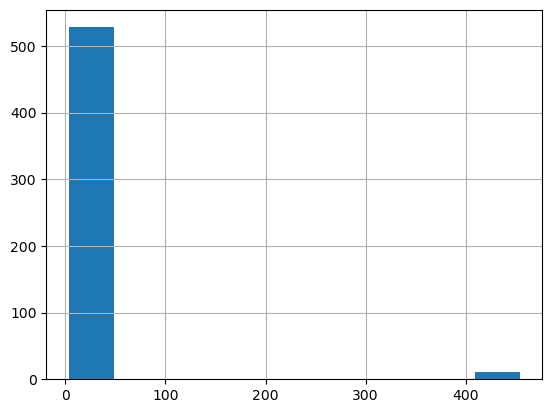

In [37]:
print(data['seller_rating'].unique())
print(data['seller_rating'].describe())
data.seller_rating.hist()

In [38]:
data['seller_rating'] = data['seller_rating'].apply(lambda x: x / 100 if x > 5 else x)

[4.2  0.43 3.7  3.9  3.5  3.8  4.4  4.1  3.6  4.8  4.12 4.3  4.54]
count    539.000000
mean       3.952356
std        0.322943
min        0.430000
25%        3.800000
50%        3.900000
75%        4.200000
max        4.800000
Name: seller_rating, dtype: float64


<Axes: >

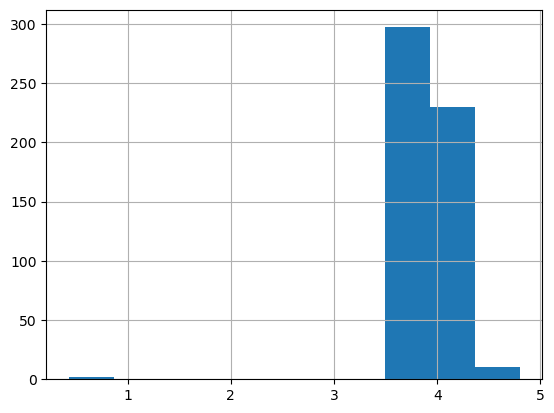

In [39]:
print(data['seller_rating'].unique())
print(data['seller_rating'].describe())
data.seller_rating.hist()

- Item rating visualisation

<Axes: >

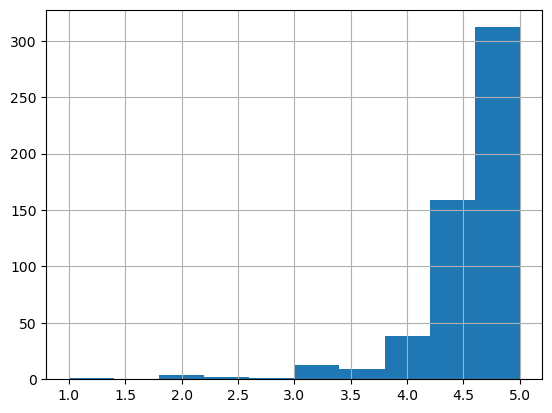

In [40]:
data.item_rating.hist()

In [41]:
data.item_rating.value_counts()

item_rating
5.0    126
4.5     71
4.8     61
4.7     58
4.6     54
4.4     47
4.0     30
4.3     25
4.2     16
4.9     13
3.0     10
4.1      7
3.7      5
2.0      4
2.3      2
3.8      2
3.4      2
3.5      1
3.3      1
3.9      1
3.6      1
2.9      1
1.0      1
Name: count, dtype: int64

In [42]:
data.head()

Unnamed: 0            brand               name  old_price  new_price   ml concentration department   scents                                 base_note                                     middle_note  item_rating seller  seller_rating  num_seller_ratings  EDP  EDT  concentration_other
0           0     paco rabanne    1 Million Lucky      395.0     244.55  100           EDT        Men    Woody              oak moss, patchouli, vetiver  hazelnut, jasmine, cashmere wood, cedar, honey          5.0   noon            4.2                98.1    0    1                    0
1           1  roberto cavalli  Paradiso Assoluto      415.0     107.95   50           EDP      Women   Floral           vanilla, sandal wood, patchouli                          wild jasmine, red lily          4.8   noon            4.2                98.1    1    0                    0
3           3            guess     Seductive Blue      290.0     103.20  100           EDT        Men    Spicy  cashmere wood, moss, rippled sand accord           blue coral aquaspace accord, geranium          3.0   noon            4.2                98.1    0    1                    0
4           4  roberto cavalli               Uomo      260.0      94.95   50           EDP      Women  Arabian              vanilla, benzoin, tonka bean                           african orange flower          4.8   noon            4.2                98.1    1    0                    0
5           5  roberto cavalli            cavalli      260.0      94.95   50           EDP      Women  Arabian              vanilla, benzoin, tonka bean                           african orange flower          4.8   noon            4.2                98.1    1    0                    0

In [43]:
data.shape

(539, 18)

## Product Differenciation

- Gender Targetting

In [44]:
per_ungendered = (66 / 1002) * 100
per_ungendered

6.58682634730539

Only 6.6 % of the perfumes are 'Unisex' ==> Gender Targetting 

- Price per milliliter comparison

In [45]:
data['price_per_ml'] = data.old_price/data.ml

In [46]:
data

Unnamed: 0               brand                             name  old_price  new_price   ml concentration department    scents                                          base_note                                        middle_note  item_rating         seller  seller_rating  num_seller_ratings  EDP  EDT  concentration_other  price_per_ml
0              0        paco rabanne                  1 Million Lucky     395.00     244.55  100           EDT        Men     Woody                       oak moss, patchouli, vetiver     hazelnut, jasmine, cashmere wood, cedar, honey          5.0           noon           4.20                98.1    0    1                    0      3.950000
1              1     roberto cavalli                Paradiso Assoluto     415.00     107.95   50           EDP      Women    Floral                    vanilla, sandal wood, patchouli                             wild jasmine, red lily          4.8           noon           4.20                98.1    1    0                    0      8.300000
3              3               guess                   Seductive Blue     290.00     103.20  100           EDT        Men     Spicy           cashmere wood, moss, rippled sand accord              blue coral aquaspace accord, geranium          3.0           noon           4.20                98.1    0    1                    0      2.900000
4              4     roberto cavalli                             Uomo     260.00      94.95   50           EDP      Women   Arabian                       vanilla, benzoin, tonka bean                              african orange flower          4.8           noon           4.20                98.1    1    0                    0      5.200000
5              5     roberto cavalli                          cavalli     260.00      94.95   50           EDP      Women   Arabian                       vanilla, benzoin, tonka bean                              african orange flower          4.8           noon           4.20                98.1    1    0                    0      5.200000
6              6           hugo boss                        The Scent     220.00     220.00   50           EDP      Women  Oriental                                      roasted cocoa                         lavender, osmanthus flower          4.0   seller_other           0.43                 4.0    1    0                    0      4.400000
7              7              dorall                      Gold Secret      43.00      12.35  100           EDT        Men    Fruity                                     labdanum, musk                                   lavender, cloves          2.9          b.a.g           3.70                14.1    0    1                    0      0.430000
8              8               gucci                           Bamboo     575.00     189.00   75           EDP      Women    Floral                                        sandal wood                casablanca lily, ylang extracomoros          4.8        al-najm           3.70               347.0    1    0                    0      7.666667
9              9  yves saint laurent                    M7 Oud Absolu     536.00     273.00   80           EDT        Men   Arabian                          cistus, myrrh, oud, amber                                          patchouli          4.5        al-najm           3.70               347.0    0    1                    0      6.700000
11            11        calvin klein                       IN 2 U MEN     152.00      85.00  100           EDT        Men    Citrus                         white musk, vetiver, cedar                                          cacao pod          3.7          amlaq           3.90               135.0    0    1                    0      1.520000
12            12              rasasi                      Royale Blue      97.00      45.30   75           EDP        Men    Fruity                         delicate musk sensual wood                                   distinct, exotic          4

In [47]:
#data.groupby('department').mean().reset_index()['price_per_ml']
mean_prices = data.groupby('department')['price_per_ml'].mean().reset_index()
print(mean_prices[['department', 'price_per_ml']])

  department  price_per_ml
0        Men      3.726766
1      Women      4.759606


In [48]:
# Extracting prices
price_men = mean_prices.loc[mean_prices['department'] == 'Men', 'price_per_ml'].values[0]
price_women = mean_prices.loc[mean_prices['department'] == 'Women', 'price_per_ml'].values[0]

# Calculating the percentage difference
per_diff = ((price_women - price_men) / price_men) * 100
per_diff


27.714105453347333

Women's perfumes are on average 27.7 % more expensive than men's perfumes

- Discount per milliliter comparison

In [49]:
data['discount_per_ml'] = (data.old_price - data.new_price)/data.ml

In [50]:
discount_prices = data.groupby('department')['discount_per_ml'].mean().reset_index()
print(discount_prices[['department', 'discount_per_ml']])

  department  discount_per_ml
0        Men         2.047465
1      Women         2.663580


In [51]:
# Extracting discounts
discount_men = discount_prices.loc[discount_prices['department'] == 'Men', 'discount_per_ml'].values[0]
discount_women = discount_prices.loc[discount_prices['department'] == 'Women', 'discount_per_ml'].values[0]

# Calculating the percentage difference
per_diff = ((discount_women - discount_men) / discount_men) * 100
per_diff


30.091566745774596

Women's perfumes have on average 30.1 % more discount than men's perfumes

In [52]:
data['discount_percent'] = (data.old_price - data.new_price)*100/data.old_price 

In [53]:
data['discount_ratio'] = (data.discount_per_ml)/data.price_per_ml

In [54]:
data_women = data[data['department'] == 'Women']
data_men = data[data['department'] == 'Men']

<Axes: >

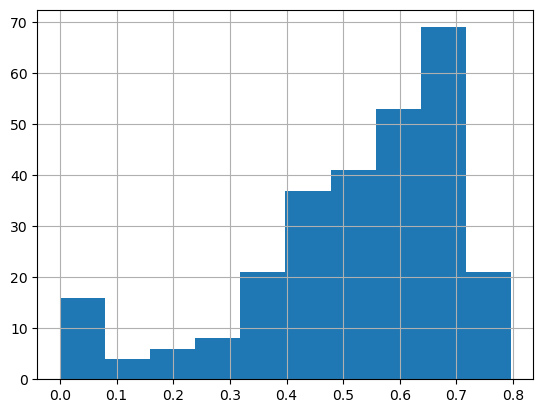

In [55]:
data_women.discount_ratio.hist()

<Axes: >

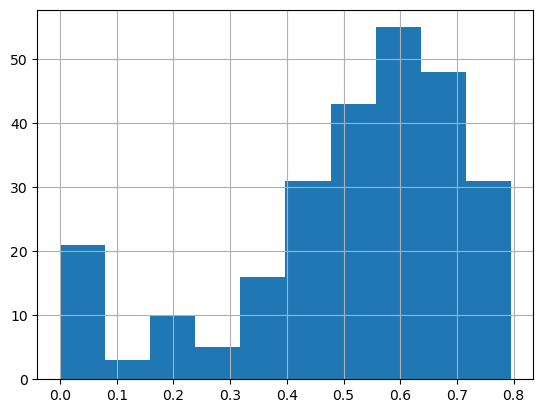

In [56]:
data_men.discount_ratio.hist()

In [57]:
discount_prices = data.groupby('department')['discount_percent'].mean().reset_index()
print(discount_prices[['department', 'discount_percent']])

  department  discount_percent
0        Men         50.765562
1      Women         52.013809


The dicount percentage is very similar for men and women

- Reduced price per milliliter difference

In [58]:
data['new_price_per_ml'] = data.new_price/data.ml
new_prices = data.groupby('department')['new_price_per_ml'].mean().reset_index()
print(new_prices[['department', 'new_price_per_ml']])

  department  new_price_per_ml
0        Men          1.679301
1      Women          2.096027


In [59]:
# Extracting discounts
new_price_men = new_prices.loc[new_prices['department'] == 'Men', 'new_price_per_ml'].values[0]
new_price_women = new_prices.loc[new_prices['department'] == 'Women', 'new_price_per_ml'].values[0]

# Calculating the percentage difference
per_diff = ((new_price_women - new_price_men) / new_price_men) * 100
per_diff


24.815417657582184

Women's perfumes are on average 24.8 % more expensive than men's perfumes after discount 
(Note that these discounts are not continuous throughout the year)

- Comparison for perfumes with the same name

In [60]:
data.name.value_counts()

name
Roses Vanille                      8
Eros                               8
Essence Pure                       7
Encre Noire                        7
Marciano                           7
Passenger                          6
Uomo                               6
Beauty                             6
Sauvage                            6
Legend                             5
Pour Femme                         5
The One                            5
Dylan Blue                         5
One Shock                          5
Crystal Noir                       5
Good Girl                          4
Burberry Body                      4
Euphoria                           4
Emblem                             4
Guilty Absolute                    4
Petits Et Mamans                   4
Florence                           4
Paradiso Assoluto                  4
My Burberry                        4
London                             4
The Scent                          4
Dare                             

In [61]:
#scents count
name_counts = data['name'].value_counts()

#names that occur more than 1 time
duplicates = name_counts[name_counts > 1].index

data_duplicates = data[data['name'].isin(duplicates)]

#data_duplicates.drop_duplicates(subset=['brand', 'name','department', 'scents', 'concentration'])

#data_duplicates.name.value_counts()

# Filter names that have at least one entry in both 'men' and 'women' departments

filtered_names = data_duplicates.groupby('name').filter(
    lambda x: 'Men' in x['department'].values and 'Women' in x['department'].values
)['name'].unique()

data_duplicates = data_duplicates[data_duplicates['name'].isin(filtered_names)]

# Calculate average prices for each gender
average_prices = data_duplicates.groupby(['name', 'brand', 'department'])['price_per_ml'].mean().unstack()

# Filter out perfumes that have average prices for both men and women
average_prices = average_prices.dropna()

# Reset the index to make it a proper DataFrame
comparison_df = average_prices.reset_index()

# Rename columns for clarity
comparison_df.columns = ['name', 'brand', 'average_men_price', 'average_women_price']

# Calculate the overall average of the average men and women prices
overall_average_men_price = comparison_df['average_men_price'].mean()
overall_average_women_price = comparison_df['average_women_price'].mean()

# Display the results
print(f"Overall average men price: {overall_average_men_price}")
print(f"Overall average women price: {overall_average_women_price}")

# Add a column to indicate whether women's perfume is more expensive
comparison_df['women_more_expensive'] = comparison_df['average_women_price'] > comparison_df['average_men_price']

comparison_df

Overall average men price: 2.989640350877193
Overall average women price: 3.6193280701754387


name             brand  average_men_price  average_women_price  women_more_expensive
0          212 Sexy  carolina herrera           3.300000             4.200000                  True
1           212 VIP  carolina herrera           2.830000             5.562500                  True
2    Boss The Scent         hugo boss           4.260000             5.350000                  True
3              Dare             guess           0.920000             1.700000                  True
4              Eros           versace           3.762500             4.616667                  True
5            Escape      calvin klein           2.350000             1.840000                 False
6      Essence Pure            dupont           2.106667             1.660000                 False
7   Guilty Absolute             gucci           5.722222             6.133333                  True
8           Lacoste           lacoste           3.680000             6.200000                  True
9       Lady Emblem         montblanc           4.250000             5.466667                  True
10         Marciano             guess           1.500000             1.193900                 False
11        One Shock      calvin klein           1.226667             0.795000                 False
12        Passenger            dupont           1.685000             3.100000                  True
13           Reveal      calvin klein           2.640000             4.270000                  True
14          Shuhrah            rasasi           0.866111             1.600000                  True
15          The One   dolce & gabbana           3.600000             1.333333                 False
16        The Scent         hugo boss           4.260000             5.033333                  True
17      Ultraviolet      paco rabanne           3.530000             3.512500                 False
18             Uomo   roberto cavalli           4.314000             5.200000                  True

On average, for a perfume with the same name, the women's perfume is 19% more expensive.

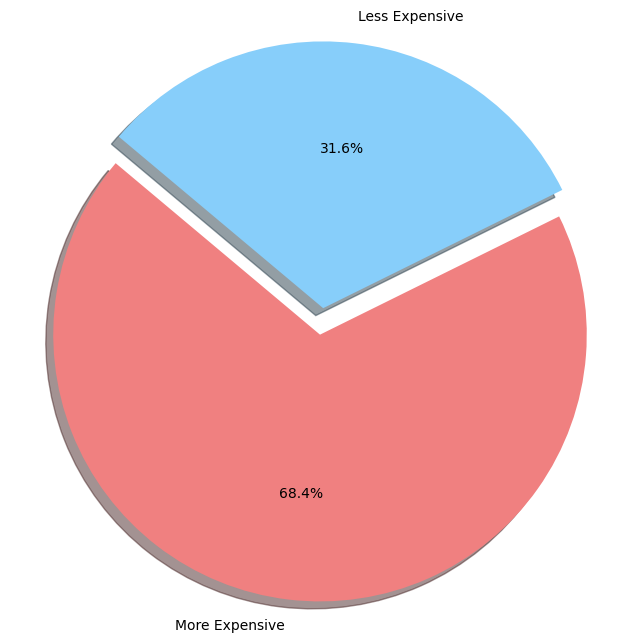

In [62]:
# Calculate percentages
women_more_expensive_pct = comparison_df['women_more_expensive'].mean() * 100
men_more_expensive_pct = 100 - women_more_expensive_pct

# Pie chart
labels = ['More Expensive', 'Less Expensive']
sizes = [women_more_expensive_pct, men_more_expensive_pct]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode the 1st slice (Women More Expensive)

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


- Descriptive analysis

In [63]:
men_perfumes = data[data['department'] == 'Men']
women_perfumes = data[data['department'] == 'Women']

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Descriptive analysis

men_perfumes.describe()

Unnamed: 0    old_price   new_price          ml  item_rating  seller_rating  num_seller_ratings         EDP         EDT  concentration_other  price_per_ml  discount_per_ml  discount_percent  discount_ratio  new_price_per_ml
count   263.000000   263.000000  263.000000  263.000000   263.000000     263.000000          263.000000  263.000000  263.000000                263.0    263.000000       263.000000        263.000000      263.000000        263.000000
mean    471.695817   348.564068  154.613992  100.844106     4.486312       3.939316          163.783270    0.152091    0.847909                  0.0      3.726766         2.047465         50.765562        0.507656          1.679301
std     299.022579   196.102267   90.648235   29.095828     0.490407       0.251599          162.316163    0.359794    0.359794                  0.0      2.395633         1.704149         20.404536        0.204045          1.111215
min       0.000000     6.500000    6.500000    1.000000     2.000000       3.500000            1.900000    0.000000    0.000000                  0.0      0.090000         0.000000          0.000000        0.000000          0.088000
25%     221.000000   220.000000   99.000000  100.000000     4.300000       3.700000           75.500000    0.000000    1.000000                  0.0      2.210000         0.911750         42.372881        0.423729          0.985000
50%     460.000000   361.000000  136.950000  100.000000     4.500000       3.900000           98.100000    0.000000    1.000000                  0.0      3.630000         2.071500         55.922865        0.559229          1.438500
75%     707.000000   452.000000  201.475000  100.000000     4.800000       4.200000          135.000000    0.000000    1.000000                  0.0      4.560000         2.745000         65.238429        0.652384          2.061250
max    1002.000000  1204.000000  560.000000  200.000000     5.000000       4.800000          538.000000    1.000000    1.000000                  0.0     17.000000        12.900000         79.519558        0.795196          7.600000

In [65]:
women_perfumes.describe()

Unnamed: 0    old_price   new_price          ml  item_rating  seller_rating  num_seller_ratings         EDP         EDT  concentration_other  price_per_ml  discount_per_ml  discount_percent  discount_ratio  new_price_per_ml
count  276.000000   276.000000  276.000000  276.000000   276.000000     276.000000          276.000000  276.000000  276.000000                276.0    276.000000       276.000000        276.000000      276.000000        276.000000
mean   568.644928   399.584601  175.563768   88.032609     4.605072       3.964783          149.202899    0.721014    0.278986                  0.0      4.759606         2.663580         52.013809        0.520138          2.096027
std    291.242949   213.434696   95.960444   21.650170     0.502911       0.378690          143.619905    0.449315    0.449315                  0.0      2.507936         1.801889         18.990760        0.189908          1.175728
min      1.000000    11.000000    7.250000    2.000000     1.000000       0.430000            1.300000    0.000000    0.000000                  0.0      0.110000         0.000000          0.000000        0.000000          0.072500
25%    338.500000   244.000000  110.000000   75.000000     4.500000       3.800000           93.000000    0.000000    0.000000                  0.0      3.050000         1.277250         43.690463        0.436905          1.379000
50%    613.000000   420.000000  165.000000  100.000000     4.700000       3.900000           98.100000    1.000000    0.000000                  0.0      4.966667         2.684500         56.111111        0.561111          1.962500
75%    829.500000   533.500000  227.700000  100.000000     5.000000       4.200000          135.000000    1.000000    1.000000                  0.0      6.653333         3.884750         66.131727        0.661317          2.601750
max    999.000000  1220.000000  515.000000  200.000000     5.000000       4.540000          538.000000    1.000000    1.000000                  0.0     12.600000         9.318500         79.611650        0.796117          7.220000

We notice that:
- The volume sold for women is on average 12.7 % less than the one sold for men ( 88.03 ml for women and 100.84 ml for men)
- There are more EDP perfumes for women, while there are more EDT perfumes for men :
      - For women perfumes: 72.1 % are EDP and 27.9 % are EDT.
      - For men perfumes: 15.2 % are EDP and 84.7 % are EDT.
- Item ratings are slightly higher for women perfumes.
- Seller ratings and Number of seller ratings are quite similar for both genders.

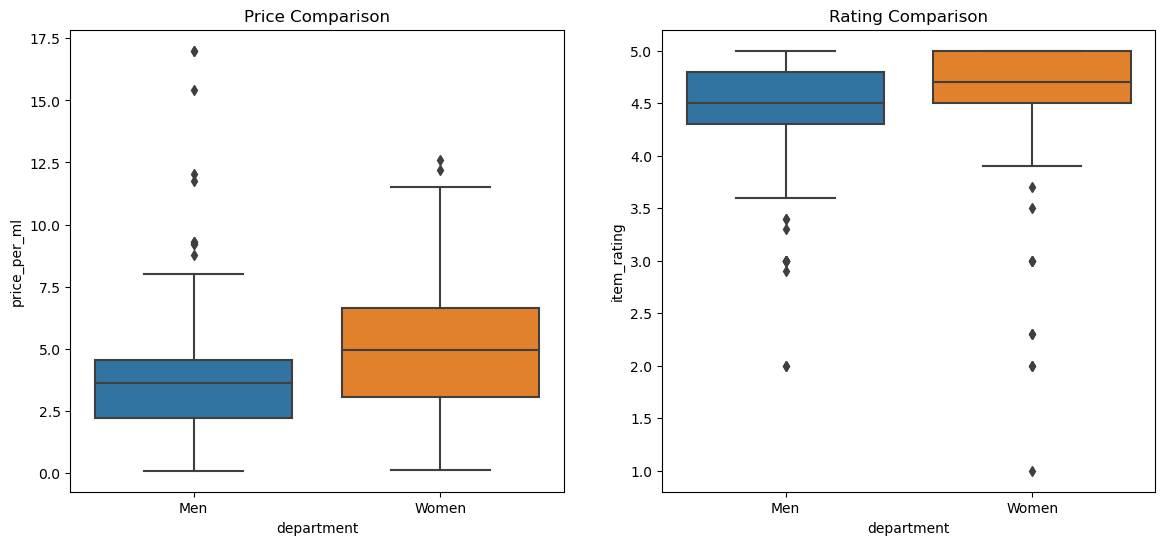

In [66]:
# Visualization
plt.figure(figsize=(14, 6))

# Price comparison
plt.subplot(1, 2, 1)
sns.boxplot(x='department', y='price_per_ml', data=data)
plt.title('Price Comparison')

# Rating comparison
plt.subplot(1, 2, 2)
sns.boxplot(x='department', y='item_rating', data=data)
plt.title('Rating Comparison')


plt.show()

In [67]:
data.drop(columns=['old_price','new_price'], inplace=True)
data

Unnamed: 0               brand                             name   ml concentration department    scents                                          base_note                                        middle_note  item_rating  ... seller_rating  num_seller_ratings  EDP  EDT  concentration_other  price_per_ml  discount_per_ml  discount_percent  discount_ratio  new_price_per_ml
0              0        paco rabanne                  1 Million Lucky  100           EDT        Men     Woody                       oak moss, patchouli, vetiver     hazelnut, jasmine, cashmere wood, cedar, honey          5.0  ...          4.20                98.1    0    1                    0      3.950000         1.504500         38.088608        0.380886          2.445500
1              1     roberto cavalli                Paradiso Assoluto   50           EDP      Women    Floral                    vanilla, sandal wood, patchouli                             wild jasmine, red lily          4.8  ...          4.20                98.1    1    0                    0      8.300000         6.141000         73.987952        0.739880          2.159000
3              3               guess                   Seductive Blue  100           EDT        Men     Spicy           cashmere wood, moss, rippled sand accord              blue coral aquaspace accord, geranium          3.0  ...          4.20                98.1    0    1                    0      2.900000         1.868000         64.413793        0.644138          1.032000
4              4     roberto cavalli                             Uomo   50           EDP      Women   Arabian                       vanilla, benzoin, tonka bean                              african orange flower          4.8  ...          4.20                98.1    1    0                    0      5.200000         3.301000         63.480769        0.634808          1.899000
5              5     roberto cavalli                          cavalli   50           EDP      Women   Arabian                       vanilla, benzoin, tonka bean                              african orange flower          4.8  ...          4.20                98.1    1    0                    0      5.200000         3.301000         63.480769        0.634808          1.899000
6              6           hugo boss                        The Scent   50           EDP      Women  Oriental                                      roasted cocoa                         lavender, osmanthus flower          4.0  ...          0.43                 4.0    1    0                    0      4.400000         0.000000          0.000000        0.000000          4.400000
7              7              dorall                      Gold Secret  100           EDT        Men    Fruity                                     labdanum, musk                                   lavender, cloves          2.9  ...          3.70                14.1    0    1                    0      0.430000         0.306500         71.279070        0.712791          0.123500
8              8               gucci                           Bamboo   75           EDP      Women    Floral                                        sandal wood                casablanca lily, ylang extracomoros          4.8  ...          3.70               347.0    1    0                    0      7.666667         5.146667         67.130435        0.671304          2.520000
9              9  yves saint laurent                    M7 Oud Absolu   80           EDT        Men   Arabian                          cistus, myrrh, oud, amber                                          patchouli          4.5  ...          3.70               347.0    0    1                    0      6.700000         3.287500         49.067164        0.490672          3.412500
11            11        calvin klein                       IN 2 U MEN  100           EDT        Men    Citrus                         white musk, vetiver, cedar                                          cacao pod          3.7  

## Base notes and middle notes

- Base Notes PCA

In [69]:
# Split the base_note values into individual words
data['base_note_words'] = data['base_note'].apply(lambda x: ', '.join(set([note.strip() for note in x.split(',')])))
data['base_note_words'] = data['base_note_words'].str.replace(', ', ' ') # Replace ', ' with space to use str.get_dummies

# Create dummy variables for each word in base_note_words
base_note_words_df = data['base_note_words'].str.get_dummies(sep=' ')

# Concatenate the dummy variables with the original DataFrame
data_with_base_note_words = pd.concat([data, base_note_words_df], axis=1)

# Drop the intermediate 'base_note_words' column
data_with_base_note_words = data_with_base_note_words.drop(['base_note_words'], axis=1)

#base_note_words_df = base_note_words_df.reindex(index=data.index, columns=middle_note_words_df.columns, fill_value=0)

base_note_words_df

absolute  acacia  accord  akigala  almond  amarelo  amber  ambrette  ambroxan  apricot  ...  virginia  vitae  warm  whisky  white  wild  wisteria  woman  wood  woodmusk
0            0       0       0        0       0        0      0         0         0        0  ...         0      0     0       0      0     0         0      0     0         0
1            0       0       0        0       0        0      0         0         0        0  ...         0      0     0       0      0     0         0      0     1         0
3            0       0       1        0       0        0      0         0         0        0  ...         0      0     0       0      0     0         0      0     1         0
4            0       0       0        0       0        0      0         0         0        0  ...         0      0     0       0      0     0         0      0     0         0
5            0       0       0        0       0        0      0         0         0        0  ...         0      0     0       0      0     0         0      0     0         0
6            0       0       0        0       0        0      0         0         0        0  ...         0      0     0       0      0     0         0      0     0         0
7            0       0       0        0       0        0      0         0         0        0  ...         0      0     0       0      0     0         0      0     0         0
8            0       0       0        0       0        0      0         0         0        0  ...         0      0     0       0      0     0         0      0     1         0
9            0       0       0        0       0        0      1         0         0        0  ...         0      0     0       0      0     0         0      0     0         0
11           0       0       0        0       0        0      0         0         0        0  ...         0      0     0       0      1     0         0      0     0         0
12           0       0       0        0       0        0      0         0         0        0  ...         0      0     0       0      0     0         0      0     1         0
14           0       0       0        0       0        0      0         0         0        0  ...         0      0     0       0      0     0         0      0     0         0
17           0       0       0        0       0        0      1         0         0        0  ...         0      0     0       0      0     0         0      0     1         0
18           0       0       0        0       0        0      1         0         0        0  ...         0      0     0       0      0     0         0      0     1         0
25           0       0       0        0       0        0      0         0         0        0  ...         0      0     0       0      0     0         0      0     0         0
26           0       0       0        0       0        0      0         0         0        0  ...         0      0     0       0      0     0         0      0     0         0
29           0       0       0        0       0        0      1         0         0        0  ...         0      0     0       0      0     0         0      0     1         0
32           0       0       0        0       0        0      0         0         0        0  ...         0      0     0       0      0     0         0      0     1         0
33           0       0       0        0       0        0      0         0         0        0  ...         0      0     0       0      0     0         0      0     0         0
35           0       0       0        0       0        0      0         0         0        0  ...         0      0     0       0      0     0         0      0     1         0
36           0       0       0        0       0        0      0         0         0        0  ...         0      0     0       0      0     0         0      0     1         0
37           0       0       0        0       0        0      0         0         0        0  ...         0      0     0       0      0     0         0     

In [70]:
# Calculate the average for each column
base_note_avg = base_note_words_df.mean().reset_index()
base_note_avg.columns = ['Base Note', 'Average']
pd.set_option('display.max_rows', None)
# Print the average table
print(base_note_avg)

         Base Note   Average
0         absolute  0.005566
1           acacia  0.001855
2           accord  0.037106
3          akigala  0.003711
4           almond  0.005566
5          amarelo  0.001855
6            amber  0.354360
7         ambrette  0.001855
8         ambroxan  0.031540
9          apricot  0.009276
10        aromatic  0.003711
11           atlas  0.005566
12      australian  0.005566
13           balsa  0.001855
14          balsam  0.007421
15            bean  0.126160
16         benzoin  0.051948
17     benzointolu  0.001855
18        bergamot  0.001855
19         berries  0.003711
20           black  0.011132
21      blackberry  0.001855
22           blond  0.003711
23           blood  0.003711
24         blossom  0.001855
25            blue  0.001855
26         bourbon  0.005566
27       brazilian  0.009276
28           brown  0.001855
29           burnt  0.003711
30           cacao  0.012987
31        cachmere  0.001855
32           cader  0.001855
33      califo

In [71]:
word_frequencies = base_note_words_df.mean()

# Identify words with a frequency greater than or equal to 0.01
frequent_words = word_frequencies[word_frequencies >= 0.01].index

# Filter the DataFrame to keep only the frequent words
filtered_base_note_words_df = base_note_words_df[frequent_words]

# Concatenate the filtered dummy variables with the original DataFrame
data_with_frequent_base_note_words = pd.concat([data, filtered_base_note_words_df], axis=1)

filtered_base_note_words_df


accord  amber  ambroxan  bean  benzoin  black  cacao  cashmere  cedar  cinnamon  ...  suede  sugar  tobacco  tonka  tree  vanilla  vetiver  virginia  white  wood
0          0      0         0     0        0      0      0         0      0         0  ...      0      0        0      0     0        0        1         0      0     0
1          0      0         0     0        0      0      0         0      0         0  ...      0      0        0      0     0        1        0         0      0     1
3          1      0         0     0        0      0      0         1      0         0  ...      0      0        0      0     0        0        0         0      0     1
4          0      0         0     1        1      0      0         0      0         0  ...      0      0        0      1     0        1        0         0      0     0
5          0      0         0     1        1      0      0         0      0         0  ...      0      0        0      1     0        1        0         0      0     0
6          0      0         0     0        0      0      0         0      0         0  ...      0      0        0      0     0        0        0         0      0     0
7          0      0         0     0        0      0      0         0      0         0  ...      0      0        0      0     0        0        0         0      0     0
8          0      0         0     0        0      0      0         0      0         0  ...      0      0        0      0     0        0        0         0      0     1
9          0      1         0     0        0      0      0         0      0         0  ...      0      0        0      0     0        0        0         0      0     0
11         0      0         0     0        0      0      0         0      1         0  ...      0      0        0      0     0        0        1         0      1     0
12         0      0         0     0        0      0      0         0      0         0  ...      0      0        0      0     0        0        0         0      0     1
14         0      0         0     1        0      0      0         0      1         0  ...      0      0        0      1     0        0        1         0      0     0
17         0      1         0     0        0      0      0         0      0         0  ...      0      0        0      0     0        1        0         0      0     1
18         0      1         0     0        0      0      0         0      1         0  ...      0      0        0      0     0        0        0         0      0     1
25         0      0         0     0        0      0      0         0      0         0  ...      0      0        0      0     0        0        0         0      0     0
26         0      0         0     0        1      0      0         0      0         0  ...      0      0        0      0     0        0        0         0      0     0
29         0      1         0     0        0      0      0         0      0         0  ...      0      0        0      0     0        0        0         0      0     1
32         0      0         0     0        0      0      0         0      0         0  ...      0      0        0      0     0        1        0         0      0     1
33         0      0         0     0        0      0      0         0      0         0  ...      0      0        0      0     0        0        0         0      0     0
35         0      0         0     1        0      0      0         0      0         0  ...      0      0        0      1     0        1        0         0      0     1
36         0      0         0     0        1      0      0         0      0         0  ...      0      0        0      0     0        0        0         0      0     1
37         0      0         0     1        0      0      0         1      0         0  ...      0      0        0      1     0        1        0         0      0     1
38         0      1         0     0        0      0      0         0      1         0  ...      0      0        0      0     0        1       

In [72]:
# Select the columns 
base_note_columns = filtered_base_note_words_df.columns
data_pca = data_with_frequent_base_note_words[base_note_columns]

# Standardize the data
scaler = StandardScaler()
data_pca_scaled = scaler.fit_transform(data_pca)

np.random.seed(42)

# Apply PCA
pca = PCA(n_components=20 , random_state = 42)
data_pca = pca.fit_transform(data_pca_scaled)

# print eigenvalues
eigenvalues = pca.explained_variance_
print(eigenvalues)

from factor_analyzer import Rotator

# Apply Varimax
rotator = Rotator(method='varimax')
rotated_loadings = rotator.fit_transform(pca.components_.T)

rotated_loadings_df = pd.DataFrame(rotated_loadings, index=base_note_columns, columns=[f'Rotated_Component_{i+1}' for i in range(rotated_loadings.shape[1])])

# Calculate the rotated factor scores by projecting the standardized data onto the rotated loadings
rotated_factor_scores = np.dot(data_pca_scaled, rotated_loadings)


# DataFrame for the rotated factor scores
rotated_factor_scores_df = pd.DataFrame(rotated_factor_scores, columns=[f'Rotated_Component_{i+1}' for i in range(rotated_factor_scores.shape[1])])

rotated_loadings_df

[2.44355015 2.39124425 2.0732513  1.94615761 1.79395105 1.62204467
 1.58695587 1.55061853 1.48590949 1.44792694 1.36021549 1.32073865
 1.25199479 1.20508311 1.16364898 1.14408971 1.09702447 1.06310319
 1.03292253 1.01202316]


Rotated_Component_1  Rotated_Component_2  Rotated_Component_3  Rotated_Component_4  Rotated_Component_5  Rotated_Component_6  Rotated_Component_7  Rotated_Component_8  Rotated_Component_9  Rotated_Component_10  Rotated_Component_11  Rotated_Component_12  Rotated_Component_13  Rotated_Component_14  Rotated_Component_15  Rotated_Component_16  Rotated_Component_17  Rotated_Component_18  Rotated_Component_19  Rotated_Component_20
accord               -0.031068            -0.032832             0.005294             0.027969            -0.007432            -0.025427             0.039299             0.037891            -0.045549              0.645521              0.101908             -0.054107              0.099609              0.059243             -0.057568              0.022346              0.047121             -0.021285              0.065756             -0.015035
amber                 0.050732            -0.077124            -0.013995             0.046096            -0.021417             0.023531            -0.121258             0.024362             0.038998             -0.067376             -0.009003              0.193360              0.030643              0.230078             -0.134351              0.024891             -0.069548              0.519054              0.007225             -0.146260
ambroxan              0.047632            -0.027811            -0.039712             0.038651            -0.000429            -0.032671             0.477115            -0.092806            -0.118559             -0.043994             -0.043575             -0.143249             -0.092864             -0.046718             -0.048995             -0.096246              0.032096             -0.160270             -0.299637             -0.024193
bean                 -0.017767             0.647260            -0.007080             0.022685             0.014046            -0.014237            -0.014252             0.040892             0.009201             -0.019484             -0.008422              0.018882              0.000070             -0.004296              0.005176             -0.014658              0.024317             -0.035352              0.009083             -0.012428
benzoin              -0.073995             0.043660             0.014980            -0.031176             0.103282            -0.018578            -0.058471            -0.086546             0.117339              0.029302             -0.025439              0.036038              0.677152              0.041063             -0.172426             -0.049684             -0.020317             -0.055920             -0.064376              0.026300
black                -0.118369            -0.038966             0.179788             0.030998             0.043102            -0.032577             0.182738             0.098373            -0.070791              0.037058             -0.053086             -0.252646              0.098273              0.140893             -0.200899              0.029460             -0.165595             -0.011414              0.325552             -0.169560
cacao                -0.066925             0.006749             0.003474             0.023783            -0.009962             0.010762             0.593788             0.035600             0.155454             -0.003427              0.012350              0.002178             -0.014365             -0.008871              0.029212             -0.014463              0.029433              0.038180              0.053417              0.043031
cashmere              0.061027            -0.030750             0.021623            -0.008514             0.044553            -0.053369             0.080672             0.020854             0.157076             -0.024123             -0.014366             -0.018429             -0.046035              0.394238              0.438057              0.055020              0.046272              0.047093              0.136369              0.014487
cedar                 0.000190            

In [73]:
rotated_component_descriptions_base = {

    'Rotated_Component_1': "base_sandal_wood",
    'Rotated_Component_2': "base_tonka_bean",
    'Rotated_Component_3': "base_moss_oak",
    'Rotated_Component_4': "base_white_accord",
    'Rotated_Component_5': "base_cedar_virginia",
    'Rotated_Component_6': "base_lemon_tree",
    'Rotated_Component_7': "base_ambroxan_cacao",
    'Rotated_Component_8': "base_saffron_incense",
    'Rotated_Component_9': "base_cinnamon_praline",
    'Rotated_Component_10': "base_coconut_accord",
    'Rotated_Component_11': "base_powdery_iris",
    'Rotated_Component_12': "base_tobacco",
    'Rotated_Component_13': "base_benzoin_guaiac",
    'Rotated_Component_14': "base_cashmere_cypress",
    'Rotated_Component_15': "base_coumarin_leather",
    'Rotated_Component_16': "base_fir_suede",
    'Rotated_Component_17': "base_amber_grey",
    'Rotated_Component_18': "base_amber_oud",
    'Rotated_Component_19': "base_rose_musk",
    'Rotated_Component_20': "base_vanilla_vetiver"
}

# Rename the columns of rotated_factor_scores_df using the descriptions
rotated_factor_scores_df.rename(columns=rotated_component_descriptions_base, inplace=True)

# Reset the indices of both DataFrames to ensure alignment
data.reset_index(drop=True, inplace=True)
rotated_factor_scores_df.reset_index(drop=True, inplace=True)

# Add the renamed columns to the original DataFrame
data = pd.concat([data, rotated_factor_scores_df], axis=1)

data

Unnamed: 0               brand                             name   ml concentration department    scents                                          base_note                                        middle_note  item_rating  ... base_powdery_iris  base_tobacco  base_benzoin_guaiac  base_cashmere_cypress  base_coumarin_leather  base_fir_suede  base_amber_grey  base_amber_oud  base_rose_musk  base_vanilla_vetiver
0             0        paco rabanne                  1 Million Lucky  100           EDT        Men     Woody                       oak moss, patchouli, vetiver     hazelnut, jasmine, cashmere wood, cedar, honey          5.0  ...         -0.312104     -0.075224            -0.166915              -1.380178              -0.465360        0.680168         0.017233       -0.223486       -0.069227              0.310562
1             1     roberto cavalli                Paradiso Assoluto   50           EDP      Women    Floral                    vanilla, sandal wood, patchouli                             wild jasmine, red lily          4.8  ...          0.164954     -0.540263            -0.271125              -0.510283               0.040725        0.430335        -0.050904       -0.166221        0.091571             -0.843651
2             3               guess                   Seductive Blue  100           EDT        Men     Spicy           cashmere wood, moss, rippled sand accord              blue coral aquaspace accord, geranium          3.0  ...          0.304125     -0.716016             0.373887               1.528134               1.387520        0.244992         0.706240       -0.627437        1.214555              0.358483
3             4     roberto cavalli                             Uomo   50           EDP      Women   Arabian                       vanilla, benzoin, tonka bean                              african orange flower          4.8  ...          0.171991      0.020828             2.918330               0.231105              -0.738296       -0.526840         0.343859       -0.986275        0.056221             -0.003629
4             5     roberto cavalli                          cavalli   50           EDP      Women   Arabian                       vanilla, benzoin, tonka bean                              african orange flower          4.8  ...          0.171991      0.020828             2.918330               0.231105              -0.738296       -0.526840         0.343859       -0.986275        0.056221             -0.003629
5             6           hugo boss                        The Scent   50           EDP      Women  Oriental                                      roasted cocoa                         lavender, osmanthus flower          4.0  ...         -0.126987     -0.255997            -0.106269              -0.175004              -0.058509       -0.073512         0.228556       -0.615954        0.095986              0.440429
6             7              dorall                      Gold Secret  100           EDT        Men    Fruity                                     labdanum, musk                                   lavender, cloves          2.9  ...         -0.245441     -0.380332            -0.107327               0.409878              -0.422564       -0.475986         0.216248       -0.424995       -3.138728              0.006699
7             8               gucci                           Bamboo   75           EDP      Women    Floral                                        sandal wood                casablanca lily, ylang extracomoros          4.8  ...         -0.169036     -0.384466            -0.138655              -0.155762               0.052033       -0.195872         0.299098       -0.691862        0.081586              0.398091
8             9  yves saint laurent                    M7 Oud Absolu   80           EDT        Men   Arabian                          cistus, myrrh, oud, amber                                          patchouli          4.5  ...         -0.094755     -0.148576          

In [74]:
base_notes_pca= [ "base_sandal_wood", "base_tonka_bean", "base_moss_oak", "base_white_accord", "base_cedar_virginia","base_lemon_tree", "base_ambroxan_cacao",
"base_saffron_incense", "base_cinnamon_praline", "base_coconut_accord", "base_powdery_iris",
 "base_tobacco", "base_benzoin_guaiac", "base_cashmere_cypress", "base_coumarin_leather",
"base_fir_suede", "base_amber_grey", "base_amber_oud", "base_rose_musk"
                ]
# "base_vanilla_vetiver"

- Middle Notes PCA

In [75]:
# Split the middle_note values into individual words
data['middle_note_words'] = data['middle_note'].apply(lambda x: ', '.join(set([note.strip() for note in x.split(',')])))
data['middle_note_words'] = data['middle_note_words'].str.replace(', ', ' ') # Replace ', ' with space to use str.get_dummies

# Create dummy variables for each word in base_note_words
middle_note_words_df = data['middle_note_words'].str.get_dummies(sep=' ')

# Concatenate the dummy variables with the original DataFrame
data_with_middle_note_words = pd.concat([data, middle_note_words_df], axis=1)

# Drop the intermediate 'middle_note_words' column
data_with_middle_note_words = data_with_middle_note_words.drop(['middle_note_words'], axis=1)

# Calculate the average for each column
middle_note_avg = middle_note_words_df.mean().reset_index()
middle_note_avg.columns = ['Middle Note', 'Average']
pd.set_option('display.max_rows', None)
# Print the average table
print(middle_note_avg)


         Middle Note   Average
0           absolute  0.014842
1             accent  0.001855
2             accord  0.011132
3            african  0.022263
4              agave  0.001855
5           alliance  0.001855
6             almond  0.007421
7          amaryllis  0.001855
8              amber  0.020408
9           ambrofix  0.001855
10          ambroxan  0.011132
11            amyris  0.001855
12                an  0.001855
13             anise  0.005566
14             apple  0.040816
15         aquaspace  0.001855
16            arabic  0.001855
17               are  0.001855
18            aromas  0.003711
19            bamboo  0.005566
20              bark  0.001855
21             basil  0.037106
22               bay  0.001855
23              bean  0.011132
24          bergamot  0.001855
25           berries  0.011132
26             birch  0.007421
27            bitter  0.001855
28             black  0.042672
29        blackberry  0.007421
30           blossom  0.094620
31      

In [76]:
word_frequencies = middle_note_words_df.mean()

# Identify words with a frequency greater than or equal to 0.01
frequent_words = word_frequencies[word_frequencies >= 0.02].index

# Filter the DataFrame to keep only the frequent words
filtered_middle_note_words_df = middle_note_words_df[frequent_words]

# Concatenate the filtered dummy variables with the original DataFrame
data_with_frequent_middle_note_words = pd.concat([data, filtered_middle_note_words_df], axis=1)

filtered_middle_note_words_df

african  amber  apple  basil  black  blossom  bulgarian  cardamom  carnation  cedar  ...  sandal  spice  tuberose  vanilla  vetiver  violet  white  wild  wood  ylang
0          0      0      0      0      0        0          0         0          0      1  ...       0      0         0        0        0       0      0     0     1      0
1          0      0      0      0      0        0          0         0          0      0  ...       0      0         0        0        0       0      0     1     0      0
2          0      0      0      0      0        0          0         0          0      0  ...       0      0         0        0        0       0      0     0     0      0
3          1      0      0      0      0        0          0         0          0      0  ...       0      0         0        0        0       0      0     0     0      0
4          1      0      0      0      0        0          0         0          0      0  ...       0      0         0        0        0       0      0     0     0      0
5          0      0      0      0      0        0          0         0          0      0  ...       0      0         0        0        0       0      0     0     0      0
6          0      0      0      0      0        0          0         0          0      0  ...       0      0         0        0        0       0      0     0     0      0
7          0      0      0      0      0        0          0         0          0      0  ...       0      0         0        0        0       0      0     0     0      1
8          0      0      0      0      0        0          0         0          0      0  ...       0      0         0        0        0       0      0     0     0      0
9          0      0      0      0      0        0          0         0          0      0  ...       0      0         0        0        0       0      0     0     0      0
10         0      0      0      0      0        0          0         0          0      0  ...       0      0         0        0        0       0      0     0     0      0
11         0      0      0      1      0        0          0         0          0      0  ...       0      1         0        0        0       1      1     0     0      0
12         0      0      0      0      0        0          0         1          0      0  ...       0      0         0        0        0       0      0     0     0      0
13         0      0      0      0      0        0          0         0          0      0  ...       0      0         0        0        0       0      0     0     0      0
14         0      0      0      0      0        0          0         0          0      0  ...       0      0         1        0        0       0      0     0     0      0
15         0      0      0      0      0        0          0         0          0      1  ...       0      0         0        0        0       0      0     0     0      0
16         0      0      0      0      0        0          0         0          1      0  ...       0      0         0        0        0       0      0     0     0      0
17         0      0      0      0      0        0          0         0          0      0  ...       0      0         0        0        0       0      0     0     0      0
18         0      1      0      0      0        0          0         0          0      1  ...       1      0         0        0        0       0      0     0     1      0
19         0      0      0      0      0        0          1         0          0      0  ...       0      0         0        0        0       0      0     0     0      0
20         0      0      0      0      0        0          0         1          0      0  ...       0      0         0        0        0       0      0     0     0      0
21         0      1      0      1      0        0          0         0          0      0  ...       0      0         0        0        0       0      0     0     0      0
22         0      0      0      0      0        0          0         0  

In [77]:
# Select the columns
middle_note_columns = filtered_middle_note_words_df.columns
data_pca = data_with_frequent_middle_note_words[middle_note_columns]

# Standardize the data
scaler = StandardScaler()
data_pca_scaled = scaler.fit_transform(data_pca)

np.random.seed(42)
# Apply PCA
pca = PCA(n_components=23, random_state = 42)
data_pca = pca.fit_transform(data_pca_scaled)

# print eigenvalues
eigenvalues = pca.explained_variance_
print(eigenvalues)

# Apply Varimax
rotator = Rotator(method='varimax')
rotated_loadings = rotator.fit_transform(pca.components_.T)

rotated_loadings_df = pd.DataFrame(rotated_loadings, index=middle_note_columns, columns=[f'Rotated_Component_{i+1}' for i in range(rotated_loadings.shape[1])])

# Calculate the rotated factor scores by projecting the standardized data onto the rotated loadings
rotated_factor_scores = np.dot(data_pca_scaled, rotated_loadings)

# DataFrame for the rotated factor scores
rotated_factor_scores_df = pd.DataFrame(rotated_factor_scores, columns=[f'Rotated_Component_{i+1}' for i in range(rotated_factor_scores.shape[1])])

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

rotated_loadings_df


[3.0213043  2.45820304 2.30009476 2.04144521 1.9722334  1.81754419
 1.72287852 1.67460055 1.56206102 1.50137799 1.46737321 1.43220689
 1.38729726 1.35511499 1.33517137 1.20960436 1.16505952 1.14841194
 1.12955302 1.10319494 1.07228537 1.02708708 1.00554071]


Rotated_Component_1  Rotated_Component_2  Rotated_Component_3  Rotated_Component_4  Rotated_Component_5  Rotated_Component_6  Rotated_Component_7  Rotated_Component_8  Rotated_Component_9  Rotated_Component_10  ...  Rotated_Component_14  Rotated_Component_15  Rotated_Component_16  Rotated_Component_17  Rotated_Component_18  Rotated_Component_19  Rotated_Component_20  Rotated_Component_21  Rotated_Component_22  Rotated_Component_23
african                 0.011202             0.014913            -0.031321            -0.010380            -0.024630            -0.024962            -0.001156            -0.008691             0.636112              0.014021  ...              0.013144             -0.001388             -0.092852             -0.037885              0.002338             -0.050539             -0.024788              0.076700             -0.015628              0.001627
amber                  -0.081265             0.041389             0.046146             0.004816             0.037131             0.014304             0.034817            -0.060128            -0.012060              0.052703  ...             -0.033647             -0.067972             -0.034430             -0.060059              0.004456              0.017260              0.757420              0.012118             -0.030733              0.006419
apple                  -0.090345            -0.008220             0.001771             0.019242            -0.055303             0.072721             0.051294             0.011995            -0.014807              0.110890  ...             -0.100337             -0.082916              0.035534             -0.010266             -0.017665             -0.088757             -0.013599             -0.046255             -0.020318             -0.266514
basil                  -0.050357            -0.054492            -0.030218            -0.035127             0.009953            -0.057197             0.586541            -0.087616            -0.033261             -0.008886  ...              0.028815             -0.060988             -0.041632             -0.044447              0.018498              0.004670             -0.014393              0.048898             -0.069363             -0.005775
black                   0.034824            -0.024935             0.033099             0.031278            -0.035478             0.090261             0.615464             0.081253            -0.005331              0.016377  ...             -0.004734              0.005613              0.020429              0.066293             -0.054955              0.028229              0.078124             -0.014127              0.020997              0.034458
blossom                -0.003593             0.008626            -0.698056             0.042299             0.002753             0.020021            -0.009539             0.022764            -0.184191              0.001806  ...              0.013795             -0.021594             -0.000870              0.008185             -0.017814             -0.009788              0.005834              0.015120              0.002669             -0.024372
bulgarian              -0.028564            -0.023448            -0.031828            -0.036758             0.013990            -0.061513            -0.009541            -0.013956             0.003364             -0.083597  ...             -0.033294             -0.062386              0.598104             -0.038587              0.043399             -0.047324              0.010236              0.191181              0.052462              0.034852
cardamom               -0.052957            -0.004452            -0.013980            -0.024994            -0.019000             0.527366             0.001665            -0.011791            -0.005138             -0.053274  ...             -0.002960             -0.026582             -0.090585              0.037643             -0.044678              0.022123              0.032517              0.118131              0.004465    

In [78]:
rotated_component_descriptions_middle = {
    'Rotated_Component_1': "middle_carnation",
    'Rotated_Component_2': "middle_sandal_wood",
    'Rotated_Component_3': "middle_orange_blossom",
    'Rotated_Component_4': "middle_floral",
    'Rotated_Component_5': "middle_clary_sage",
    'Rotated_Component_6': "middle_ginger_cardamom",
    'Rotated_Component_7': "middle_black_basil",
    'Rotated_Component_8': "middle_violet_leaf",
    'Rotated_Component_9': "middle_apple_flower",
    'Rotated_Component_10': "middle_lavender",
    'Rotated_Component_11': "middle_muguet_freesia",
    'Rotated_Component_12': "middle_peach",
    'Rotated_Component_13': "middle_iris_jasmine",
    'Rotated_Component_14': "middle_pineapple_rose",
    'Rotated_Component_15': "middle_neroli",
    'Rotated_Component_16': "middle_cyclamen",
    'Rotated_Component_17': "middle_honeysuckle",
    'Rotated_Component_18': "middle_iris",
    'Rotated_Component_19': "middle_vanilla",
    'Rotated_Component_20': "middle_patchouli",
    'Rotated_Component_21': "middle_sambac",
    'Rotated_Component_22': "middle_geranium",
    'Rotated_Component_23': "middle_bulgarian_rose"
}

# Rename the columns of rotated_factor_scores_df using the descriptions
rotated_factor_scores_df.rename(columns=rotated_component_descriptions_middle, inplace=True)

# Reset the indices of both DataFrames to ensure alignment
data.reset_index(drop=True, inplace=True)
rotated_factor_scores_df.reset_index(drop=True, inplace=True)

# Add the renamed columns to the original DataFrame
data = pd.concat([data, rotated_factor_scores_df], axis=1)
data

Unnamed: 0               brand                             name   ml concentration department    scents                                          base_note                                        middle_note  item_rating  ... middle_pineapple_rose  middle_neroli  middle_cyclamen  middle_honeysuckle  middle_iris  middle_vanilla  middle_patchouli  middle_sambac  middle_geranium  middle_bulgarian_rose
0             0        paco rabanne                  1 Million Lucky  100           EDT        Men     Woody                       oak moss, patchouli, vetiver     hazelnut, jasmine, cashmere wood, cedar, honey          5.0  ...             -0.361591       0.431851        -0.139228           -0.149493     0.081808       -0.572990         -0.476240      -0.502890        -0.107344              -0.068493
1             1     roberto cavalli                Paradiso Assoluto   50           EDP      Women    Floral                    vanilla, sandal wood, patchouli                             wild jasmine, red lily          4.8  ...             -1.051655      -0.397383         0.395445           -0.280968    -0.582343       -1.086937          0.025611      -1.617594        -0.074997              -2.611041
2             3               guess                   Seductive Blue  100           EDT        Men     Spicy           cashmere wood, moss, rippled sand accord              blue coral aquaspace accord, geranium          3.0  ...              0.134398       0.376219        -0.423227           -0.157604     0.244662       -0.240675          0.240174      -0.390335         0.365075               1.054406
3             4     roberto cavalli                             Uomo   50           EDP      Women   Arabian                       vanilla, benzoin, tonka bean                              african orange flower          4.8  ...             -0.168383      -0.269192        -0.864855           -0.222790    -0.176931       -0.418591         -0.207080       0.086984         0.032597               0.400865
4             5     roberto cavalli                          cavalli   50           EDP      Women   Arabian                       vanilla, benzoin, tonka bean                              african orange flower          4.8  ...             -0.168383      -0.269192        -0.864855           -0.222790    -0.176931       -0.418591         -0.207080       0.086984         0.032597               0.400865
5             6           hugo boss                        The Scent   50           EDP      Women  Oriental                                      roasted cocoa                         lavender, osmanthus flower          4.0  ...             -0.372569      -0.496289        -0.863361            0.659709     0.026517       -0.286826          0.006372      -0.006904        -0.474880               0.080735
6             7              dorall                      Gold Secret  100           EDT        Men    Fruity                                     labdanum, musk                                   lavender, cloves          2.9  ...             -0.348363      -0.912848        -1.364761            0.088044     4.754551       -0.082519          0.380181       0.319425        -0.202302              -0.058313
7             8               gucci                           Bamboo   75           EDP      Women    Floral                                        sandal wood                casablanca lily, ylang extracomoros          4.8  ...             -0.577184       2.318112         0.266757           -0.712522     0.544278        0.723287          0.135285      -0.743101        -0.257585               0.941246
8             9  yves saint laurent                    M7 Oud Absolu   80           EDT        Men   Arabian                          cistus, myrrh, oud, amber                                          patchouli          4.5  ...             -0.374248      -0.013986        -0.318506           -0.136613    -0.114489       -0.585145          1.613777      -0.65

In [79]:
middle_notes_pca = [
"middle_carnation", "middle_sandal_wood", "middle_orange_blossom", "middle_floral",
"middle_clary_sage", "middle_ginger_cardamom", "middle_black_basil", "middle_violet_leaf",
"middle_apple_flower", "middle_lavender", "middle_muguet_freesia", "middle_peach",
"middle_iris_jasmine", "middle_pineapple_rose", "middle_neroli", "middle_cyclamen",
 "middle_honeysuckle", "middle_iris", "middle_vanilla", "middle_patchouli",
 "middle_sambac", "middle_geranium"
    ]
# "middle_bulgarian_rose"

## Correlation between variables and price per ml/ Discount percentage

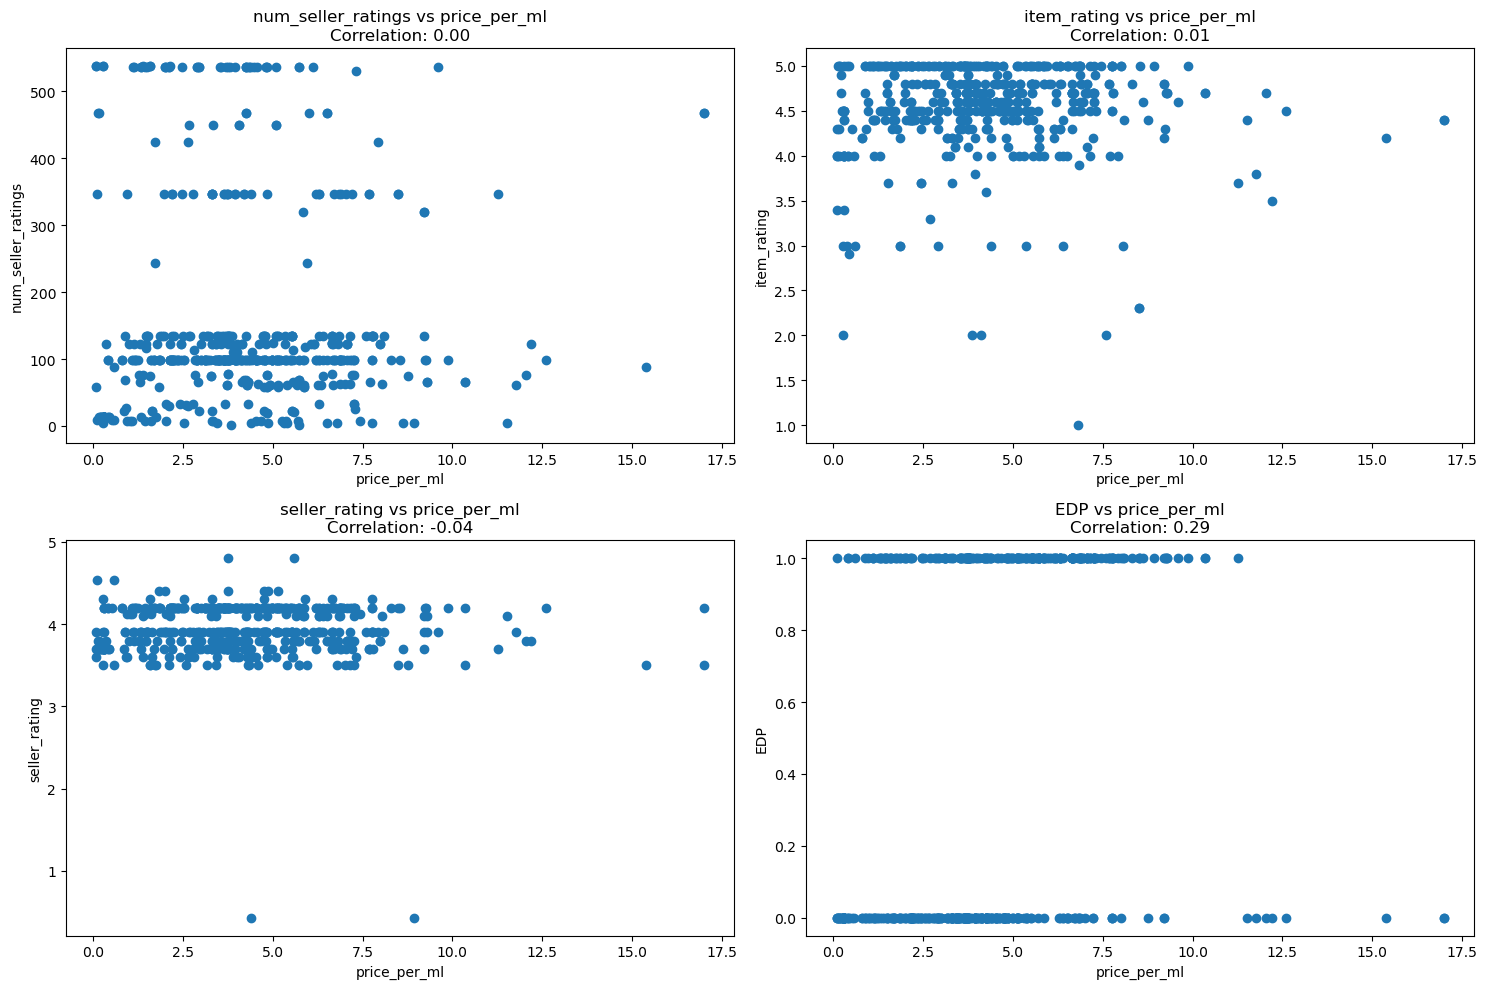

In [80]:
# Calculate correlations
correlations = {
    'num_seller_ratings': data['price_per_ml'].corr(data['num_seller_ratings']),
    'item_rating': data['price_per_ml'].corr(data['item_rating']),
    'seller_rating': data['price_per_ml'].corr(data['seller_rating']),
    'EDP': data['price_per_ml'].corr(data['EDP']),
}

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (key, value) in enumerate(correlations.items()):
    axes[i].scatter(data['price_per_ml'], data[key])
    axes[i].set_title(f'{key} vs price_per_ml\nCorrelation: {value:.2f}')
    axes[i].set_xlabel('price_per_ml')
    axes[i].set_ylabel(key)

plt.tight_layout()
plt.show()

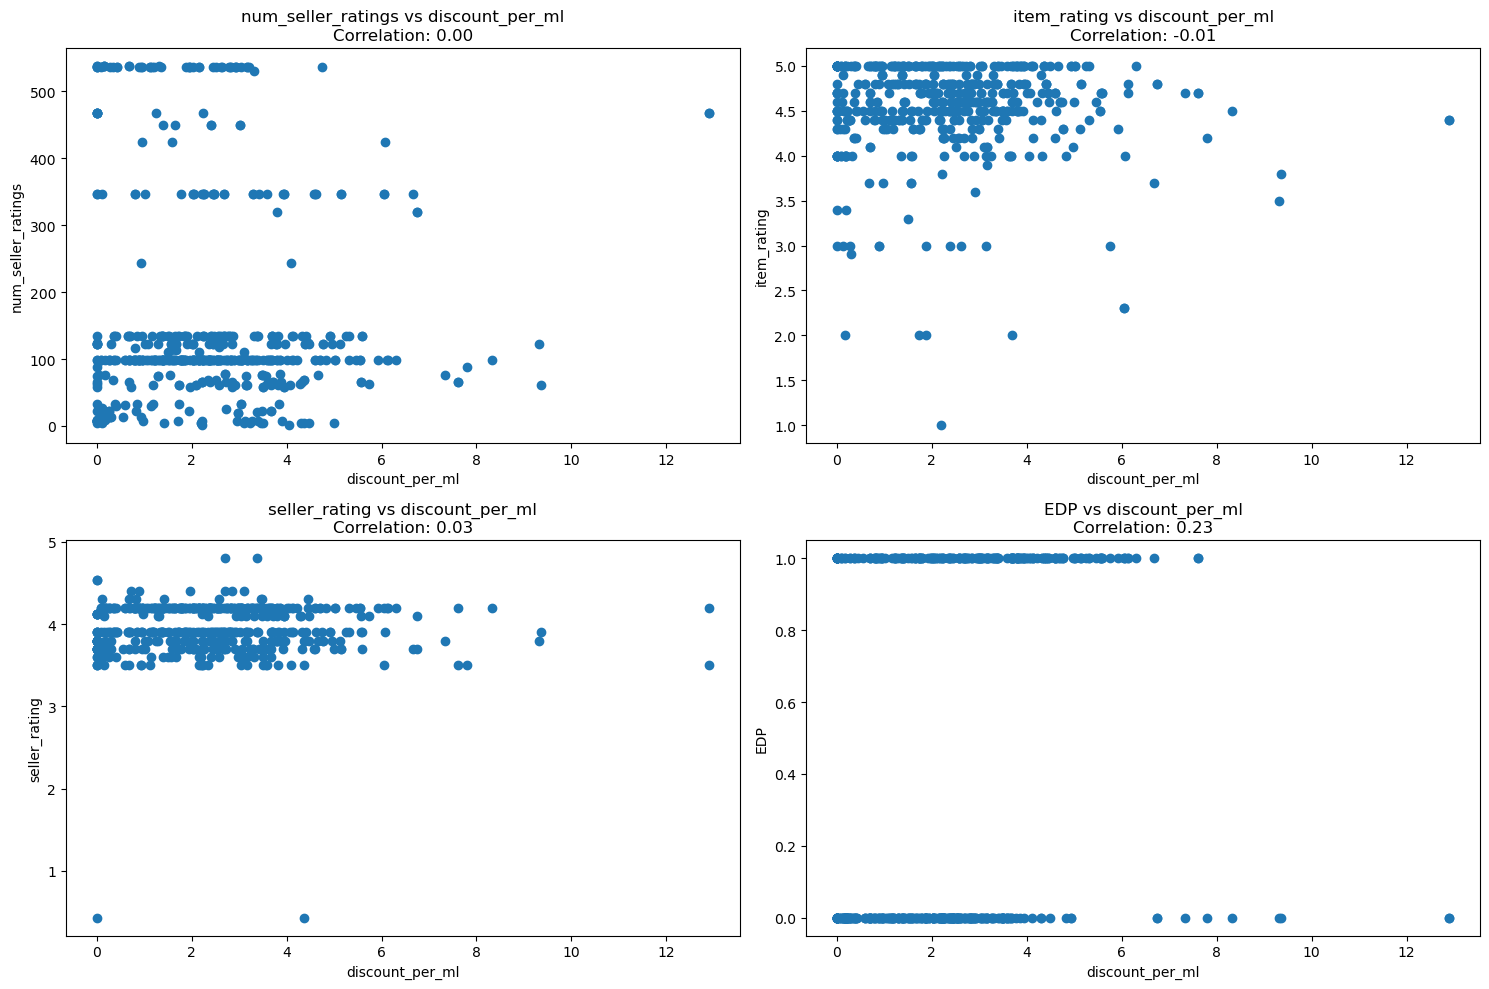

In [81]:
# Calculate correlations
correlations = {
    'num_seller_ratings': data['discount_per_ml'].corr(data['num_seller_ratings']),
    'item_rating': data['discount_per_ml'].corr(data['item_rating']),
    'seller_rating': data['discount_per_ml'].corr(data['seller_rating']),
    'EDP': data['discount_per_ml'].corr(data['EDP']),
}

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (key, value) in enumerate(correlations.items()):
    axes[i].scatter(data['discount_per_ml'], data[key])
    axes[i].set_title(f'{key} vs discount_per_ml\nCorrelation: {value:.2f}')
    axes[i].set_xlabel('discount_per_ml')
    axes[i].set_ylabel(key)

plt.tight_layout()
plt.show()

## Regression

In [82]:
data

Unnamed: 0               brand                             name   ml concentration department    scents                                          base_note                                        middle_note  item_rating  ... middle_pineapple_rose  middle_neroli  middle_cyclamen  middle_honeysuckle  middle_iris  middle_vanilla  middle_patchouli  middle_sambac  middle_geranium  middle_bulgarian_rose
0             0        paco rabanne                  1 Million Lucky  100           EDT        Men     Woody                       oak moss, patchouli, vetiver     hazelnut, jasmine, cashmere wood, cedar, honey          5.0  ...             -0.361591       0.431851        -0.139228           -0.149493     0.081808       -0.572990         -0.476240      -0.502890        -0.107344              -0.068493
1             1     roberto cavalli                Paradiso Assoluto   50           EDP      Women    Floral                    vanilla, sandal wood, patchouli                             wild jasmine, red lily          4.8  ...             -1.051655      -0.397383         0.395445           -0.280968    -0.582343       -1.086937          0.025611      -1.617594        -0.074997              -2.611041
2             3               guess                   Seductive Blue  100           EDT        Men     Spicy           cashmere wood, moss, rippled sand accord              blue coral aquaspace accord, geranium          3.0  ...              0.134398       0.376219        -0.423227           -0.157604     0.244662       -0.240675          0.240174      -0.390335         0.365075               1.054406
3             4     roberto cavalli                             Uomo   50           EDP      Women   Arabian                       vanilla, benzoin, tonka bean                              african orange flower          4.8  ...             -0.168383      -0.269192        -0.864855           -0.222790    -0.176931       -0.418591         -0.207080       0.086984         0.032597               0.400865
4             5     roberto cavalli                          cavalli   50           EDP      Women   Arabian                       vanilla, benzoin, tonka bean                              african orange flower          4.8  ...             -0.168383      -0.269192        -0.864855           -0.222790    -0.176931       -0.418591         -0.207080       0.086984         0.032597               0.400865
5             6           hugo boss                        The Scent   50           EDP      Women  Oriental                                      roasted cocoa                         lavender, osmanthus flower          4.0  ...             -0.372569      -0.496289        -0.863361            0.659709     0.026517       -0.286826          0.006372      -0.006904        -0.474880               0.080735
6             7              dorall                      Gold Secret  100           EDT        Men    Fruity                                     labdanum, musk                                   lavender, cloves          2.9  ...             -0.348363      -0.912848        -1.364761            0.088044     4.754551       -0.082519          0.380181       0.319425        -0.202302              -0.058313
7             8               gucci                           Bamboo   75           EDP      Women    Floral                                        sandal wood                casablanca lily, ylang extracomoros          4.8  ...             -0.577184       2.318112         0.266757           -0.712522     0.544278        0.723287          0.135285      -0.743101        -0.257585               0.941246
8             9  yves saint laurent                    M7 Oud Absolu   80           EDT        Men   Arabian                          cistus, myrrh, oud, amber                                          patchouli          4.5  ...             -0.374248      -0.013986        -0.318506           -0.136613    -0.114489       -0.585145          1.613777      -0.65

In [83]:
first_row = data.iloc[0]
print(first_row)


Unnamed: 0                                                             0
brand                                                       paco rabanne
name                                                     1 Million Lucky
ml                                                                   100
concentration                                                        EDT
department                                                           Men
scents                                                             Woody
base_note                                   oak moss, patchouli, vetiver
middle_note               hazelnut, jasmine, cashmere wood, cedar, honey
item_rating                                                          5.0
seller                                                              noon
seller_rating                                                        4.2
num_seller_ratings                                                  98.1
EDP                                                

In [84]:
data.columns

Index(['Unnamed: 0', 'brand', 'name', 'ml', 'concentration', 'department', 'scents', 'base_note', 'middle_note', 'item_rating', 'seller', 'seller_rating', 'num_seller_ratings', 'EDP', 'EDT', 'concentration_other', 'price_per_ml', 'discount_per_ml', 'discount_percent', 'discount_ratio', 'new_price_per_ml', 'base_note_words', 'base_sandal_wood', 'base_tonka_bean', 'base_moss_oak', 'base_white_accord', 'base_cedar_virginia', 'base_lemon_tree', 'base_ambroxan_cacao', 'base_saffron_incense', 'base_cinnamon_praline', 'base_coconut_accord', 'base_powdery_iris', 'base_tobacco', 'base_benzoin_guaiac', 'base_cashmere_cypress', 'base_coumarin_leather', 'base_fir_suede', 'base_amber_grey', 'base_amber_oud', 'base_rose_musk', 'base_vanilla_vetiver', 'middle_note_words', 'middle_carnation', 'middle_sandal_wood', 'middle_orange_blossom', 'middle_floral', 'middle_clary_sage', 'middle_ginger_cardamom', 'middle_black_basil', 'middle_violet_leaf', 'middle_apple_flower', 'middle_lavender', 'middle_muguet_

<Axes: >

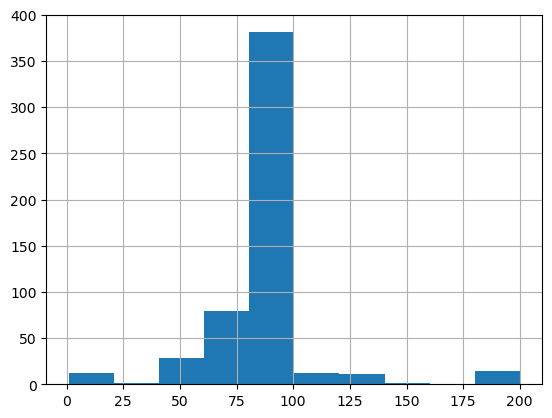

In [85]:
data.ml.hist()

In [86]:
data['log_ml'] = np.log(data['ml'])

In [87]:
data_fixed_ml = data[data['ml'] == 100]

In [88]:
data_fixed_ml.shape

(330, 67)

<Axes: >

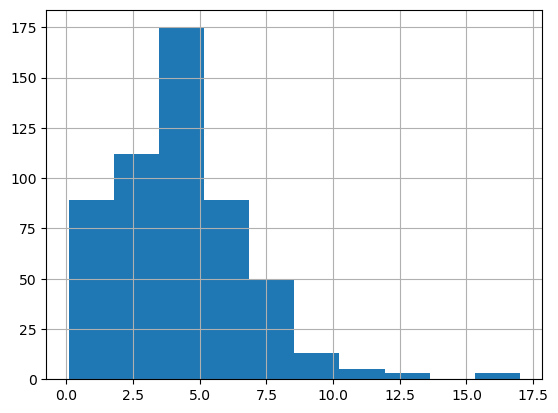

In [89]:
data.price_per_ml.hist()

In [90]:
#data.ln_price_ml.hist()

In [91]:
data.ml.describe()

count    539.000000
mean      94.283859
std       26.323889
min        1.000000
25%       90.000000
50%      100.000000
75%      100.000000
max      200.000000
Name: ml, dtype: float64

In [92]:
data

Unnamed: 0               brand                             name   ml concentration department    scents                                          base_note                                        middle_note  item_rating  ... middle_neroli  middle_cyclamen  middle_honeysuckle  middle_iris  middle_vanilla  middle_patchouli  middle_sambac  middle_geranium  middle_bulgarian_rose    log_ml
0             0        paco rabanne                  1 Million Lucky  100           EDT        Men     Woody                       oak moss, patchouli, vetiver     hazelnut, jasmine, cashmere wood, cedar, honey          5.0  ...      0.431851        -0.139228           -0.149493     0.081808       -0.572990         -0.476240      -0.502890        -0.107344              -0.068493  4.605170
1             1     roberto cavalli                Paradiso Assoluto   50           EDP      Women    Floral                    vanilla, sandal wood, patchouli                             wild jasmine, red lily          4.8  ...     -0.397383         0.395445           -0.280968    -0.582343       -1.086937          0.025611      -1.617594        -0.074997              -2.611041  3.912023
2             3               guess                   Seductive Blue  100           EDT        Men     Spicy           cashmere wood, moss, rippled sand accord              blue coral aquaspace accord, geranium          3.0  ...      0.376219        -0.423227           -0.157604     0.244662       -0.240675          0.240174      -0.390335         0.365075               1.054406  4.605170
3             4     roberto cavalli                             Uomo   50           EDP      Women   Arabian                       vanilla, benzoin, tonka bean                              african orange flower          4.8  ...     -0.269192        -0.864855           -0.222790    -0.176931       -0.418591         -0.207080       0.086984         0.032597               0.400865  3.912023
4             5     roberto cavalli                          cavalli   50           EDP      Women   Arabian                       vanilla, benzoin, tonka bean                              african orange flower          4.8  ...     -0.269192        -0.864855           -0.222790    -0.176931       -0.418591         -0.207080       0.086984         0.032597               0.400865  3.912023
5             6           hugo boss                        The Scent   50           EDP      Women  Oriental                                      roasted cocoa                         lavender, osmanthus flower          4.0  ...     -0.496289        -0.863361            0.659709     0.026517       -0.286826          0.006372      -0.006904        -0.474880               0.080735  3.912023
6             7              dorall                      Gold Secret  100           EDT        Men    Fruity                                     labdanum, musk                                   lavender, cloves          2.9  ...     -0.912848        -1.364761            0.088044     4.754551       -0.082519          0.380181       0.319425        -0.202302              -0.058313  4.605170
7             8               gucci                           Bamboo   75           EDP      Women    Floral                                        sandal wood                casablanca lily, ylang extracomoros          4.8  ...      2.318112         0.266757           -0.712522     0.544278        0.723287          0.135285      -0.743101        -0.257585               0.941246  4.317488
8             9  yves saint laurent                    M7 Oud Absolu   80           EDT        Men   Arabian                          cistus, myrrh, oud, amber                                          patchouli          4.5  ...     -0.013986        -0.318506           -0.136613    -0.114489       -0.585145          1.613777      -0.657883         0.301708               0.340036  4.382027
9            11        calvin klein                       IN 2 U MEN  100           E

- Price per ml

In [93]:
import statsmodels.formula.api as sm
import statsmodels.formula.api as smf

data['ln_price_ml'] = np.log(data.price_per_ml)

department_ref = 'Men'
brand_ref = 'chanel'
seller_ref = 'seller_other'
concentration_ref = 'EDT'
# Define the formula

formula = f"price_per_ml ~ C(department, Treatment(reference='{department_ref}'))+ C(brand, Treatment(reference='{brand_ref}'))  + C(seller, Treatment(reference='{seller_ref}'))+ C(concentration, Treatment(reference='{concentration_ref}')) + log_ml + log_ml*C(concentration, Treatment(reference='{concentration_ref}')) "


# Perform the regression

for component in middle_notes_pca:
    formula += f" + Q('{component}')"

for component in base_notes_pca:
    formula += f" + Q('{component}')"

#for component in combined_notes_pca:
#    formula += f" + Q('{component}')"
    
result = smf.ols(formula=formula, data=data).fit()

estimate_table = pd.DataFrame({
    'Variable'   : result.params.index,
    'Coefficient': result.params.values,
    'Std Err'    : result.bse.values,
    't-value'    : result.tvalues.values,
    'P>|t|'      : result.pvalues.values,
    '[0.025'     : result.conf_int().iloc[:, 0],
    '0.975]'     : result.conf_int().iloc[:, 1]
}).round(2)


In [94]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           price_per_ml   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     17.54
Date:                Tue, 29 Oct 2024   Prob (F-statistic):           1.35e-95
Time:                        09:36:53   Log-Likelihood:                -896.71
No. Observations:                 539   AIC:                             1945.
Df Residuals:                     463   BIC:                             2271.
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                          15.1616      0.867     17.485      0.000      13.458      16.866
C(department, Treatment(reference='Men'))[T.Women]                  0.5867      0.226      2.595      0.010       0.142       1.031
C(brand, Treatment(reference='chanel'))[T.armani]                  -3.9483      0.618     -6.392      0.000      -5.162      -2.734
C(brand, Treatment(reference='chanel'))[T.burberry]                -5.2239      0.593     -8.816      0.000      -6.388      -4.060
C(brand, Treatment(reference='chanel'))[T.bvlgari]                 -4.8202      0.666     -7.242      0.000      -6.128      -3.512
C(brand, Treatment(reference='chanel'))[T.calvin klein]            -7.0782      0.600    -11.801      0.000      -8.257      -5.899
C(brand, Treatment(reference='chanel'))[T.carolina herrera]        -5.2136      0.621     -8.390      0.000      -6.435      -3.992
C(brand, Treatment(reference='chanel'))[T.cartier]                 -4.2886      0.664     -6.458      0.000      -5.594      -2.984
C(brand, Treatment(reference='chanel'))[T.dior]                    -3.0731      0.743     -4.136      0.000      -4.533      -1.613
C(brand, Treatment(reference='chanel'))[T.dolce & gabbana]         -5.4736      0.608     -9.006      0.000      -6.668      -4.279
C(brand, Treatment(reference='chanel'))[T.dorall]                  -9.9751      0.708    -14.097      0.000     -11.366      -8.585
C(brand, Treatment(reference='chanel'))[T.dupont]                  -6.9100      0.656    -10.527      0.000      -8.200      -5.620
C(brand, Treatment(reference='chanel'))[T.givenchy]                -3.7080      0.621     -5.970      0.000      -4.928      -2.487
C(brand, Treatment(reference='chanel'))[T.gucci]                   -4.1402      0.605     -6.841      0.000      -5.329      -2.951
C(brand, Treatment(reference='chanel'))[T.guerlain]                -4.2197      0.667     -6.327      0.000      -5.530      -2.909
C(brand, Treatment(reference='chanel'))[T.guess]                   -7.1629      0.673    -10.640      0.000      -8.486      -5.840
C(brand, Treatment(reference='chanel'))[T.hugo boss]               -5.5270      0.597     -9.251      0.000      -6.701      -4.353
C(brand, Treatment(reference='chanel'))[T.lacoste]                 -5.9907      0.615     -9.747      0.000      -7.199      -4.783
C(brand, Treatment(reference='chanel'))[T.lalique]                 -6.4100      0.706     -9.081      0.000      -7.797      -5.023
C(brand, Treatment(reference='chanel'))[T.mancera]                 -5.7007      0.827     -6.893      0.000      -7.326      -4.075
C(brand, Treatment(reference='chanel'))[T.montb

In [95]:
data_edt = data[data['concentration'] == 'EDT']
data_edp = data[data['concentration'] == 'EDP']

data['ln_item_rating'] = np.log(data.item_rating)

formula = f"ln_item_rating ~ C(brand, Treatment(reference='{brand_ref}')) + scents + price_per_ml + EDT "

for component in middle_notes_pca:
    formula += f" + Q('{component}')"

for component in base_notes_pca:
    formula += f" + Q('{component}')"
    
#for component in middle_notes_pca:
#    formula += f" + Q('{component}')*EDT"

#for component in base_notes_pca:
#    formula += f" + Q('{component}')*EDT"

result = smf.ols(formula=formula, data=data).fit()

estimate_table = pd.DataFrame({
    'Variable'   : result.params.index,
    'Coefficient': result.params.values,
    'Std Err'    : result.bse.values,
    't-value'    : result.tvalues.values,
    'P>|t|'      : result.pvalues.values,
    '[0.025'     : result.conf_int().iloc[:, 0],
    '0.975]'     : result.conf_int().iloc[:, 1]
}).round(2)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ln_item_rating   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1.187
Date:                Tue, 29 Oct 2024   Prob (F-statistic):              0.148
Time:                        09:37:01   Log-Likelihood:                 338.36
No. Observations:                 539   AIC:                            -520.7
Df Residuals:                     461   BIC:                            -186.1
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                         1.6292      0.070     23.206      0.000       1.491       1.767
C(brand, Treatment(reference='chanel'))[T.armani]                -0.0752      0.064     -1.179      0.239      -0.200       0.050
C(brand, Treatment(reference='chanel'))[T.burberry]              -0.1258      0.062     -2.038      0.042      -0.247      -0.005
C(brand, Treatment(reference='chanel'))[T.bvlgari]               -0.0551      0.070     -0.791      0.429      -0.192       0.082
C(brand, Treatment(reference='chanel'))[T.calvin klein]          -0.1197      0.066     -1.801      0.072      -0.250       0.011
C(brand, Treatment(reference='chanel'))[T.carolina herrera]      -0.0653      0.067     -0.980      0.327      -0.196       0.066
C(brand, Treatment(reference='chanel'))[T.cartier]               -0.0469      0.068     -0.688      0.492      -0.181       0.087
C(brand, Treatment(reference='chanel'))[T.dior]                  -0.2172      0.076     -2.861      0.004      -0.366      -0.068
C(brand, Treatment(reference='chanel'))[T.dolce & gabbana]       -0.0771      0.065     -1.186      0.236      -0.205       0.051
C(brand, Treatment(reference='chanel'))[T.dorall]                -0.2129      0.072     -2.969      0.003      -0.354      -0.072
C(brand, Treatment(reference='chanel'))[T.dupont]                -0.0893      0.070     -1.273      0.204      -0.227       0.049
C(brand, Treatment(reference='chanel'))[T.givenchy]              -0.1405      0.064     -2.196      0.029      -0.266      -0.015
C(brand, Treatment(reference='chanel'))[T.gucci]                 -0.1247      0.062     -2.014      0.045      -0.246      -0.003
C(brand, Treatment(reference='chanel'))[T.guerlain]              -0.0939      0.068     -1.386      0.166      -0.227       0.039
C(brand, Treatment(reference='chanel'))[T.guess]                 -0.1006      0.073     -1.383      0.167      -0.244       0.042
C(brand, Treatment(reference='chanel'))[T.hugo boss]             -0.1198      0.064     -1.881      0.061      -0.245       0.005
C(brand, Treatment(reference='chanel'))[T.lacoste]               -0.1150      0.066     -1.743      0.082      -0.245       0.015
C(brand, Treatment(reference='chanel'))[T.lalique]               -0.0940      0.075     -1.249      0.212      -0.242       0.054
C(brand, Treatment(reference='chanel'))[T.mancera]               -0.0287      0.087     -0.331      0.741      -0.199       0.141
C(brand, Treatment(reference='chanel'))[T.montblanc]             -0.0002      0.068     -0.003      0.998      -0.133       0.133
C(brand, Treatment(reference='chanel'))[T.paco rabanne]          -0.0616      0.067     -0.91

- Discount per ml

In [96]:
# Define the formula

formula = f"discount_per_ml ~ C(department, Treatment(reference='{department_ref}'))+ C(brand, Treatment(reference='{brand_ref}'))  + C(seller, Treatment(reference='{seller_ref}'))+ C(concentration, Treatment(reference='{concentration_ref}')) + log_ml + log_ml*C(concentration, Treatment(reference='{concentration_ref}'))"

for component in middle_notes_pca:
    formula += f" + Q('{component}')"

for component in base_notes_pca:
    formula += f" + Q('{component}')"

result = smf.ols(formula=formula, data=data).fit()
estimate_table = pd.DataFrame({
    'Variable'   : result.params.index,
    'Coefficient': result.params.values,
    'Std Err'    : result.bse.values,
    't-value'    : result.tvalues.values,
    'P>|t|'      : result.pvalues.values,
    '[0.025'     : result.conf_int().iloc[:, 0],
    '0.975]'     : result.conf_int().iloc[:, 1]
}).round(2)


In [97]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        discount_per_ml   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     6.635
Date:                Tue, 29 Oct 2024   Prob (F-statistic):           2.72e-39
Time:                        09:37:02   Log-Likelihood:                -878.44
No. Observations:                 539   AIC:                             1909.
Df Residuals:                     463   BIC:                             2235.
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                           7.6409      0.838      9.115      0.000       5.994       9.288
C(department, Treatment(reference='Men'))[T.Women]                  0.5366      0.219      2.455      0.014       0.107       0.966
C(brand, Treatment(reference='chanel'))[T.armani]                  -2.6940      0.597     -4.511      0.000      -3.868      -1.521
C(brand, Treatment(reference='chanel'))[T.burberry]                -3.1140      0.573     -5.437      0.000      -4.240      -1.988
C(brand, Treatment(reference='chanel'))[T.bvlgari]                 -3.4352      0.643     -5.339      0.000      -4.700      -2.171
C(brand, Treatment(reference='chanel'))[T.calvin klein]            -4.3927      0.580     -7.576      0.000      -5.532      -3.253
C(brand, Treatment(reference='chanel'))[T.carolina herrera]        -3.3956      0.601     -5.653      0.000      -4.576      -2.215
C(brand, Treatment(reference='chanel'))[T.cartier]                 -2.5503      0.642     -3.973      0.000      -3.812      -1.289
C(brand, Treatment(reference='chanel'))[T.dior]                    -2.0297      0.718     -2.826      0.005      -3.441      -0.618
C(brand, Treatment(reference='chanel'))[T.dolce & gabbana]         -3.5491      0.588     -6.041      0.000      -4.704      -2.395
C(brand, Treatment(reference='chanel'))[T.dorall]                  -6.1650      0.684     -9.012      0.000      -7.509      -4.821
C(brand, Treatment(reference='chanel'))[T.dupont]                  -4.2705      0.635     -6.730      0.000      -5.517      -3.024
C(brand, Treatment(reference='chanel'))[T.givenchy]                -2.5379      0.600     -4.227      0.000      -3.718      -1.358
C(brand, Treatment(reference='chanel'))[T.gucci]                   -3.2610      0.585     -5.574      0.000      -4.411      -2.111
C(brand, Treatment(reference='chanel'))[T.guerlain]                -3.1814      0.645     -4.934      0.000      -4.448      -1.914
C(brand, Treatment(reference='chanel'))[T.guess]                   -4.3190      0.651     -6.637      0.000      -5.598      -3.040
C(brand, Treatment(reference='chanel'))[T.hugo boss]               -3.2350      0.578     -5.601      0.000      -4.370      -2.100
C(brand, Treatment(reference='chanel'))[T.lacoste]                 -3.4972      0.594     -5.886      0.000      -4.665      -2.330
C(brand, Treatment(reference='chanel'))[T.lalique]                 -4.0550      0.682     -5.943      0.000      -5.396      -2.714
C(brand, Treatment(reference='chanel'))[T.mancera]                 -4.5160      0.799     -5.649      0.000      -6.087      -2.945
C(brand, Treatment(reference='chanel'))[T.montb

- Discount percentage

In [98]:

# Define the formula
formula = f"discount_percent ~C(department, Treatment(reference='{department_ref}')) + C(seller, Treatment(reference='{seller_ref}'))+ C(concentration, Treatment(reference='{concentration_ref}')) + log_ml + log_ml*C(concentration, Treatment(reference='{concentration_ref}'))  + seller_rating "

for component in middle_notes_pca:
    formula += f" + Q('{component}')"

for component in base_notes_pca:
    formula += f" + Q('{component}')"

result = smf.ols(formula=formula, data=data).fit()
estimate_table = pd.DataFrame({
    'Variable'   : result.params.index,
    'Coefficient': result.params.values,
    'Std Err'    : result.bse.values,
    't-value'    : result.tvalues.values,
    'P>|t|'      : result.pvalues.values,
    '[0.025'     : result.conf_int().iloc[:, 0],
    '0.975]'     : result.conf_int().iloc[:, 1]
}).round(2)


In [99]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       discount_percent   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     2.116
Date:                Tue, 29 Oct 2024   Prob (F-statistic):           2.39e-05
Time:                        09:37:03   Log-Likelihood:                -2315.4
No. Observations:                 539   AIC:                             4737.
Df Residuals:                     486   BIC:                             4964.
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                           2.9208     14.140      0.207      0.836     -24.862      30.704
C(department, Treatment(reference='Men'))[T.Women]                  6.2279      2.915      2.137      0.033       0.501      11.955
C(seller, Treatment(reference='seller_other'))[T.al-najm]          12.6017      4.351      2.896      0.004       4.053      21.151
C(seller, Treatment(reference='seller_other'))[T.amlaq]             5.5880      3.003      1.861      0.063      -0.313      11.489
C(seller, Treatment(reference='seller_other'))[T.b.a.g]            18.9190      4.712      4.015      0.000       9.661      28.177
C(seller, Treatment(reference='seller_other'))[T.hadayiq baris]     5.3814      3.619      1.487      0.138      -1.730      12.493
C(seller, Treatment(reference='seller_other'))[T.noon]              4.4403      2.285      1.943      0.053      -0.049       8.930
C(seller, Treatment(reference='seller_other'))[T.star.perfume]     -1.9591      4.398     -0.445      0.656     -10.601       6.683
C(concentration, Treatment(reference='EDT'))[T.EDP]                -4.3941     15.964     -0.275      0.783     -35.762      26.973
log_ml                                                              3.6874      1.865      1.977      0.049       0.023       7.352
log_ml:C(concentration, Treatment(reference='EDT'))[T.EDP]          1.1263      3.587      0.314      0.754      -5.922       8.175
seller_rating                                                       6.3310      2.994      2.115      0.035       0.449      12.213
Q('middle_carnation')                                              -0.8432      0.781     -1.080      0.281      -2.377       0.691
Q('middle_sandal_wood')                                             0.2295      0.599      0.383      0.702      -0.947       1.406
Q('middle_orange_blossom')                                         -0.1817      0.671     -0.271      0.787      -1.500       1.136
Q('middle_floral')                                                 -1.5300      0.686     -2.229      0.026      -2.878      -0.182
Q('middle_clary_sage')                                              0.2225      0.711      0.313      0.755      -1.176       1.620
Q('middle_ginger_cardamom')                                         0.4289      0.707      0.607      0.544      -0.959       1.817
Q('middle_black_basil')                                             0.8744      0.734      1.191      0.234      -0.568       2.317
Q('middle_violet_leaf')                                            -1.0445      0.712     -1.467      0.143      -2.444       0.355
Q('middle_apple_flower')                       

- Discounted price

In [100]:
data['ln_new_price_ml'] = np.log(data.new_price_per_ml)
# Define the formula
formula = f"new_price_per_ml ~C(department, Treatment(reference='{department_ref}'))+ C(brand, Treatment(reference='{brand_ref}'))  + C(seller, Treatment(reference='{seller_ref}'))+ C(concentration, Treatment(reference='{concentration_ref}')) + log_ml + log_ml*C(concentration, Treatment(reference='{concentration_ref}')) "

for component in middle_notes_pca:
    formula += f" + Q('{component}')"

for component in base_notes_pca:
    formula += f" + Q('{component}')"

result = smf.ols(formula=formula, data=data).fit()
estimate_table = pd.DataFrame({
    'Variable'   : result.params.index,
    'Coefficient': result.params.values,
    'Std Err'    : result.bse.values,
    't-value'    : result.tvalues.values,
    'P>|t|'      : result.pvalues.values,
    '[0.025'     : result.conf_int().iloc[:, 0],
    '0.975]'     : result.conf_int().iloc[:, 1]
}).round(2)


In [101]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       new_price_per_ml   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     18.24
Date:                Tue, 29 Oct 2024   Prob (F-statistic):           2.16e-98
Time:                        09:37:04   Log-Likelihood:                -474.90
No. Observations:                 539   AIC:                             1102.
Df Residuals:                     463   BIC:                             1428.
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                           7.5207      0.396     18.969      0.000       6.742       8.300
C(department, Treatment(reference='Men'))[T.Women]                  0.0501      0.103      0.484      0.628      -0.153       0.253
C(brand, Treatment(reference='chanel'))[T.armani]                  -1.2543      0.282     -4.441      0.000      -1.809      -0.699
C(brand, Treatment(reference='chanel'))[T.burberry]                -2.1099      0.271     -7.788      0.000      -2.642      -1.577
C(brand, Treatment(reference='chanel'))[T.bvlgari]                 -1.3850      0.304     -4.551      0.000      -1.983      -0.787
C(brand, Treatment(reference='chanel'))[T.calvin klein]            -2.6855      0.274     -9.792      0.000      -3.224      -2.147
C(brand, Treatment(reference='chanel'))[T.carolina herrera]        -1.8179      0.284     -6.398      0.000      -2.376      -1.260
C(brand, Treatment(reference='chanel'))[T.cartier]                 -1.7383      0.304     -5.725      0.000      -2.335      -1.142
C(brand, Treatment(reference='chanel'))[T.dior]                    -1.0434      0.340     -3.072      0.002      -1.711      -0.376
C(brand, Treatment(reference='chanel'))[T.dolce & gabbana]         -1.9246      0.278     -6.925      0.000      -2.471      -1.378
C(brand, Treatment(reference='chanel'))[T.dorall]                  -3.8101      0.324    -11.776      0.000      -4.446      -3.174
C(brand, Treatment(reference='chanel'))[T.dupont]                  -2.6395      0.300     -8.795      0.000      -3.229      -2.050
C(brand, Treatment(reference='chanel'))[T.givenchy]                -1.1701      0.284     -4.120      0.000      -1.728      -0.612
C(brand, Treatment(reference='chanel'))[T.gucci]                   -0.8792      0.277     -3.177      0.002      -1.423      -0.335
C(brand, Treatment(reference='chanel'))[T.guerlain]                -1.0383      0.305     -3.405      0.001      -1.638      -0.439
C(brand, Treatment(reference='chanel'))[T.guess]                   -2.8439      0.308     -9.240      0.000      -3.449      -2.239
C(brand, Treatment(reference='chanel'))[T.hugo boss]               -2.2920      0.273     -8.390      0.000      -2.829      -1.755
C(brand, Treatment(reference='chanel'))[T.lacoste]                 -2.4936      0.281     -8.873      0.000      -3.046      -1.941
C(brand, Treatment(reference='chanel'))[T.lalique]                 -2.3551      0.323     -7.297      0.000      -2.989      -1.721
C(brand, Treatment(reference='chanel'))[T.mancera]                 -1.1846      0.378     -3.133      0.002      -1.928      -0.442
C(brand, Treatment(reference='chanel'))[T.montb

In [102]:
data = data.drop(['num_seller_ratings', 'ml','base_note', 'middle_note', 'EDP' , 'EDT', 'concentration_other', 'Unnamed: 0','discount_percent', 'discount_ratio' , 'base_note_words' , 'middle_note_words', 'ln_price_ml', 'ln_item_rating', 'ln_new_price_ml' ], axis=1)


In [103]:
data = data.drop(['base_sandal_wood', 'base_tonka_bean', 'base_moss_oak', 'base_white_accord', 'base_cedar_virginia', 'base_lemon_tree', 'base_ambroxan_cacao', 'base_saffron_incense', 'base_cinnamon_praline', 'base_coconut_accord', 'base_powdery_iris', 'base_tobacco', 'base_benzoin_guaiac', 'base_cashmere_cypress', 'base_coumarin_leather', 'base_fir_suede', 'base_amber_grey', 'base_amber_oud', 'base_rose_musk', 'base_vanilla_vetiver', 'middle_carnation', 'middle_sandal_wood', 'middle_orange_blossom', 'middle_floral', 'middle_clary_sage', 'middle_ginger_cardamom', 'middle_black_basil', 'middle_violet_leaf', 'middle_apple_flower', 'middle_lavender', 'middle_muguet_freesia', 'middle_peach', 'middle_iris_jasmine', 'middle_pineapple_rose', 'middle_neroli', 'middle_cyclamen', 'middle_honeysuckle', 'middle_iris', 'middle_vanilla', 'middle_patchouli', 'middle_sambac', 'middle_geranium', 'middle_bulgarian_rose'], axis=1)


In [104]:
data.to_csv('data_pink_tax.csv', index=True)